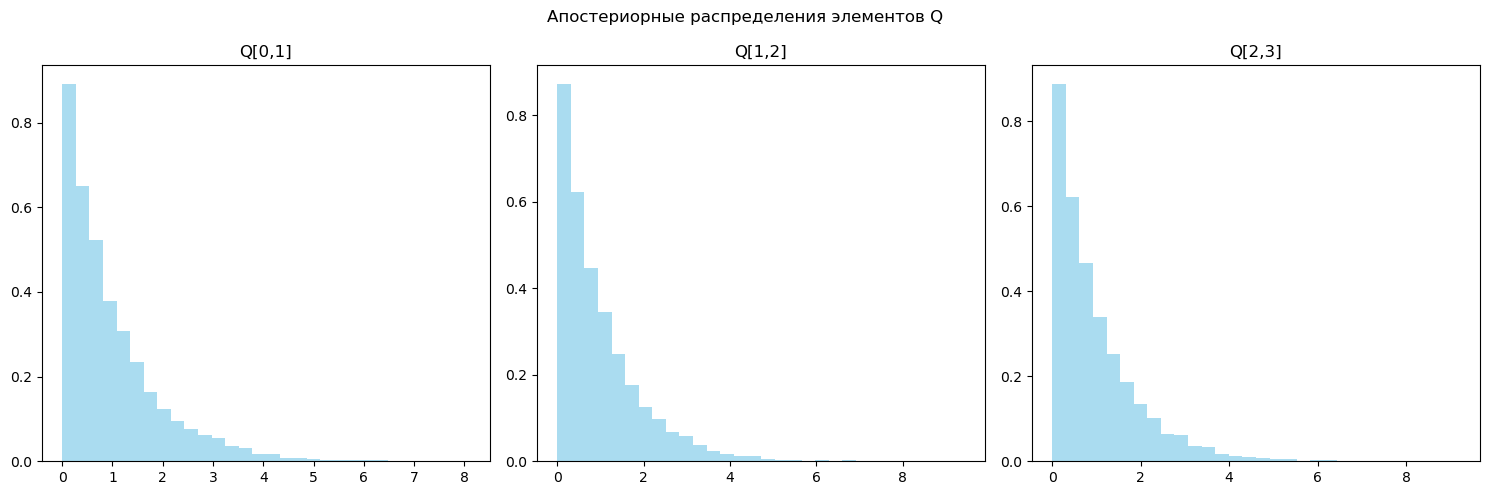

In [38]:
import numpy as np
from scipy.stats import expon, gamma
import matplotlib.pyplot as plt

# Настройки
n_states = 4  # количество состояний (например: AAA, AA, A, дефолт)
alpha = 1.0   # параметр Дирихле/гамма-распределения
beta = 1.0
num_iters = 10000
burn_in = 2000

# Начальная матрица Q
initial_q = np.array([
    [-0.3, 0.2, 0.1, 0.0],
    [0.0, -0.4, 0.3, 0.1],
    [0.0, 0.0, -0.5, 0.5],
    [0.0, 0.0, 0.0, 0.0]  # дефолт – поглощающее состояние
])

def simulate_jumps(q, max_time=100):
    current_state = 0
    jumps = []
    time = 0.0
    
    while time < max_time and current_state != n_states - 1:
        rate = -q[current_state, current_state]
        if rate <= 0:
            break

        dwell_time = expon.rvs(scale=1/rate)
        probs = q[current_state, :].copy()
        probs[current_state] = 0
        probs = np.maximum(probs, 0)
        if probs.sum() <= 0:
            break
        probs /= probs.sum()
        
        next_state = np.random.choice(n_states, p=probs)
        jumps.append((current_state, next_state, dwell_time))
        time += dwell_time
        current_state = next_state
    return jumps

def update_q(q, jumps):
    n_ij = np.zeros((n_states, n_states))
    r_i = np.zeros(n_states)
    
    for (i, j, t) in jumps:
        n_ij[i, j] += 1
        r_i[i] += t

    new_q = np.zeros_like(q)
    for i in range(n_states - 1):  # дефолт не обновляется
        for j in range(n_states):
            if i != j:
                new_alpha = alpha + n_ij[i, j]
                new_beta = beta + r_i[i]
                new_q[i, j] = gamma.rvs(new_alpha, scale=1/new_beta)
        new_q[i, i] = -np.sum(new_q[i, :])
    return new_q

# BMCMC-итерации
samples = []
q = initial_q.copy()

for it in range(num_iters):
    jumps = simulate_jumps(q)
    q = update_q(q, jumps)
    
    if it >= burn_in:
        samples.append(q.copy())

# Пример: гистограммы некоторых элементов Q
samples = np.array(samples)
plt.figure(figsize=(15, 5))
for idx, (i, j) in enumerate([(0, 1), (1, 2), (2, 3)]):
    plt.subplot(1, 3, idx + 1)
    plt.hist(samples[:, i, j], bins=30, density=True, alpha=0.7, color='skyblue')
    plt.title(f"Q[{i},{j}]")
plt.suptitle("Апостериорные распределения элементов Q")
plt.tight_layout()
plt.show()


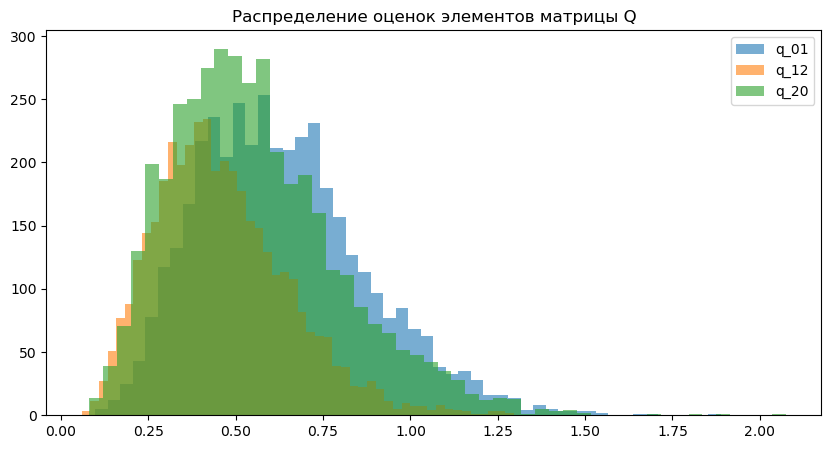

In [42]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def bmcmc_simulation(N, R, alpha, beta, num_samples=4000):
    """
    Байесовская MCMC-оценка матрицы переходных вероятностей.
    
    :param N: матрица наблюдаемых переходов (размер m x m)
    :param R: вектор времени пребывания в состояниях (размер m)
    :param alpha: априорные параметры формы гамма-распределения (размер m x m)
    :param beta: априорные параметры масштаба гамма-распределения (размер m)
    :param num_samples: количество итераций MCMC
    :return: массив сгенерированных матриц Q
    """
    m = N.shape[0]  # Количество состояний
    samples = np.zeros((num_samples, m, m))
    
    for s in range(num_samples):
        Q = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                if i != j:
                    shape = N[i, j] + alpha[i, j]
                    scale = 1 / (R[i] + beta[i])
                    Q[i, j] = np.random.gamma(shape, scale)
            Q[i, i] = -np.sum(Q[i, :])  # Диагональные элементы
        samples[s] = Q
    
    return samples

m = 3 # Число состояний
N = np.array([[0, 5, 3], [2, 0, 4], [3, 1, 0]])  # Количество переходов
R = np.array([10, 12, 8])  # Время пребывания в состояниях
alpha = np.ones((m, m)) * 2  # Априорное значение alpha
beta = np.ones(m) * 1  # Априорное значение beta

samples = bmcmc_simulation(N, R, alpha, beta)

plt.figure(figsize=(10, 5))
plt.hist(samples[:, 0, 1], bins=50, alpha=0.6, label='q_01')
plt.hist(samples[:, 1, 2], bins=50, alpha=0.6, label='q_12')
plt.hist(samples[:, 2, 0], bins=50, alpha=0.6, label='q_20')
plt.legend()
plt.title("Распределение оценок элементов матрицы Q")
plt.show()


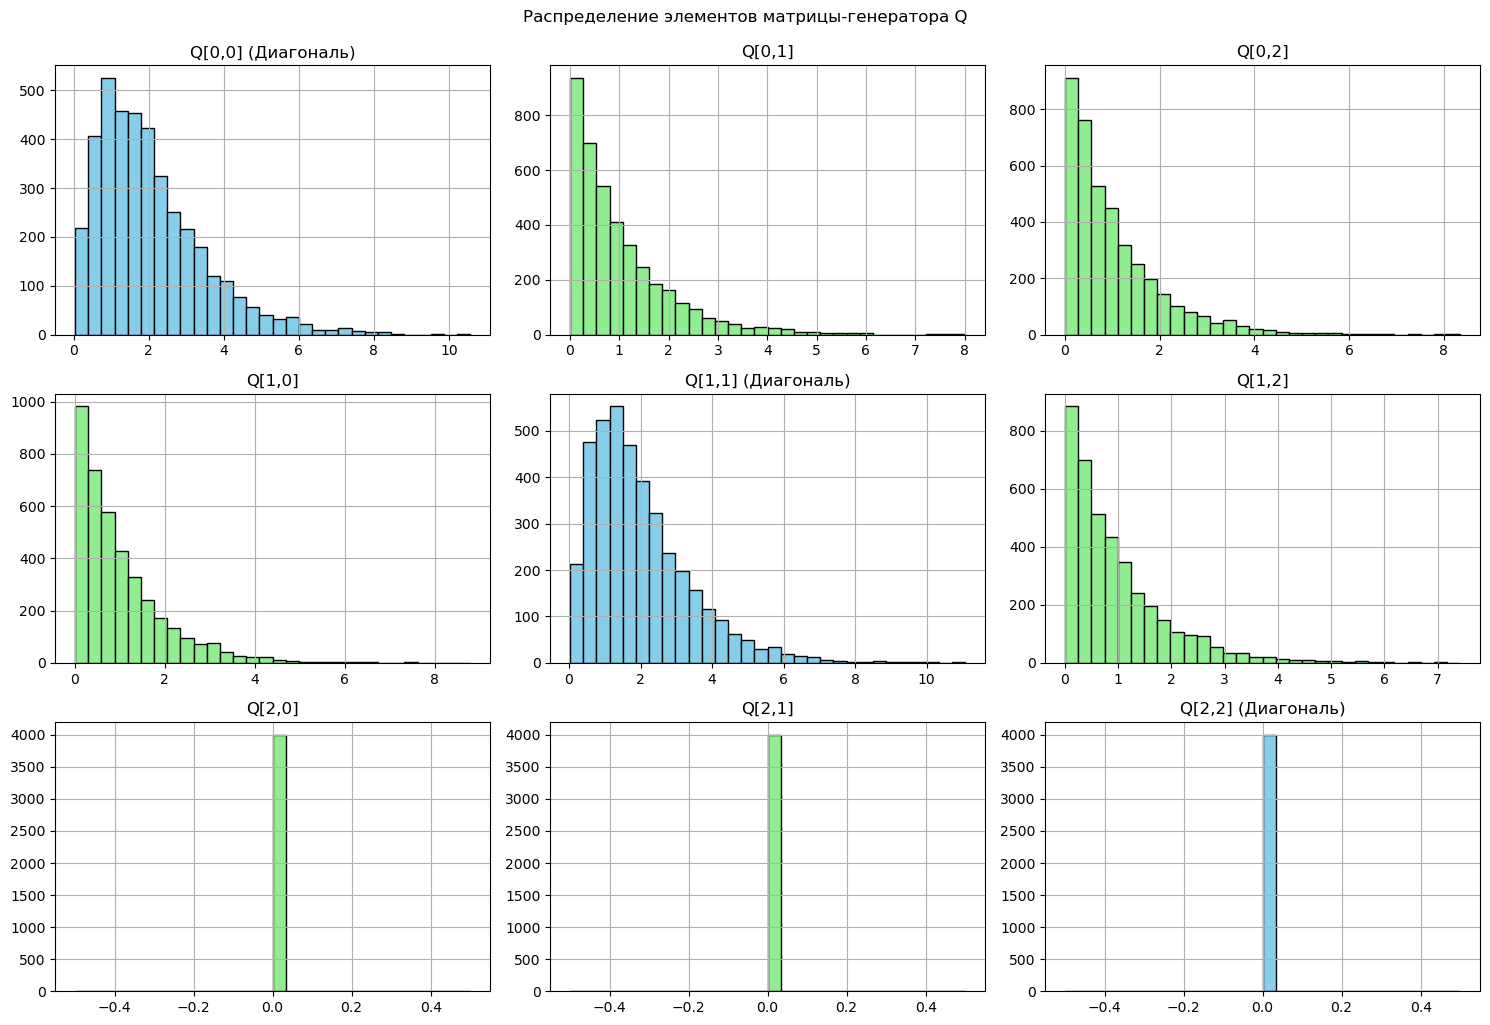

тоговая оценка матрицы Q:
[[-2.048  1.025  1.022]
 [ 1.024 -2.006  0.983]
 [ 0.     0.     0.   ]]


In [40]:
import numpy as np
from scipy.stats import gamma, expon
import matplotlib.pyplot as plt

# param
states = ['A', 'B', 'D']
n_states = len(states)
burn_in = 1000
iterations = 4000
alpha = 1.0
beta = 1.0

# Inicialization Q
def initialize_q():
    q = np.zeros((n_states, n_states))
    for i in range(n_states - 1):
        for j in range(n_states):
            if i != j:
                q[i, j] = gamma.rvs(alpha, scale=1/beta)
        q[i, i] = -np.sum(q[i, :])
    return q

# Simulation
def simulate_jumps(q, max_time=100):
    current_state = 0
    jumps = []
    time = 0.0
    
    while time < max_time and current_state != n_states - 1:
        rate = -q[current_state, current_state]
        if rate <= 0:
            break
            
        dwell_time = expon.rvs(scale=1/rate)
        probs = q[current_state, :].copy()
        probs[current_state] = 0
        probs = np.maximum(probs, 0)
        if probs.sum() <= 0:
            break
        probs /= probs.sum()
        
        next_state = np.random.choice(n_states, p=probs)
        jumps.append((current_state, next_state, dwell_time))
        time += dwell_time
        current_state = next_state
    return jumps

# Update Q
def update_q(q, jumps):
    n_ij = np.zeros((n_states, n_states))
    r_i = np.zeros(n_states)
    
    for (i, j, t) in jumps:
        n_ij[i, j] += 1
        r_i[i] += t
    
    new_q = np.zeros_like(q)
    for i in range(n_states - 1):
        for j in range(n_states):
            if i != j:
                new_alpha = alpha + n_ij[i, j]
                new_beta = beta + r_i[i]
                new_q[i, j] = gamma.rvs(new_alpha, scale=1/new_beta)
        new_q[i, i] = -np.sum(new_q[i, :])
    return new_q

# MCMC
# np.random.seed(42)
q_chain = []
current_q = initialize_q()

for step in range(burn_in + iterations):
    jumps = simulate_jumps(current_q)
    if len(jumps) > 0:
        current_q = update_q(current_q, jumps)
    
    if step >= burn_in and len(jumps) > 0:
        q_chain.append(current_q.copy())

# Main body
if q_chain:
    q_chain = np.array(q_chain)
    fig, axes = plt.subplots(n_states, n_states, figsize=(15, 10))
    
    for i in range(n_states):
        for j in range(n_states):
            ax = axes[i, j]
            if i == j:
                ax.set_title(f'Q[{i},{j}] (Диагональ)')
                ax.hist(-q_chain[:, i, i], bins=30, color='skyblue', edgecolor='black')
            else:
                ax.set_title(f'Q[{i},{j}]')
                ax.hist(q_chain[:, i, j], bins=30, color='lightgreen', edgecolor='black')
            ax.grid(True)
    
    plt.tight_layout()
    plt.suptitle('Распределение элементов матрицы-генератора Q', y=1.02)
    plt.show()
    
    # Вывод итоговой оценки
    final_q = np.mean(q_chain, axis=0)
    print("тоговая оценка матрицы Q:")
    print(np.round(final_q, 3))
else:
    print("Не удалось получить оценки.")

Рассмотрим PyMVC

In [4]:
pip install pymc arviz


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 3.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 5.0 MB/s eta 0:00:00a 0:00:01
  Created wheel for cons: filename=cons-0.4.6-py3-none-any.whl size=9098 sha256=c3954903c7c4e9669d8fad559f94e7576a40c213134898480da17fb8f3463d01
  Stored in directory: /Users/danilalipatov/Library/Caches/pip/wheels/95/8f/45/fe0a5b5e232401da571d514eb545833fbe220993ac8336c94e
  Created wheel for logical-unification: filename=lo

In [1]:
import numpy as np
import pymc as pm
import arviz as az

In [2]:
# Кол-во наблюдаемых переходов между рейтингами (упрощённые данные)
N = np.array([
    [50, 10,  0,  0,  0],
    [5,  40, 5,  0,  0],
    [0,   5, 45, 5,  0],
    [0,   0, 5, 40, 5],
    [0,   0, 0,  5, 50]
])

K = N.shape[0]

with pm.Model() as model:
    # Матрица переходов: каждая строка — Dirichlet
    P = pm.Dirichlet("P", a=np.ones_like(N) + N, shape=N.shape)

    # Наблюдаемые переходы
    for i in range(K):
        pm.Multinomial(f"obs_{i}", n=N[i].sum(), p=P[i], observed=N[i])

    trace = pm.sample(2000, tune=1000, chains=3, target_accept=0.8)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [P]


Output()

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 42 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P[0, 0]  0.808  0.035   0.741    0.871        0.0    0.000    7734.0   
P[0, 1]  0.168  0.033   0.109    0.231        0.0    0.000    7740.0   
P[0, 2]  0.008  0.008   0.000    0.023        0.0    0.000    3137.0   
P[0, 3]  0.008  0.008   0.000    0.021        0.0    0.000    3260.0   
P[0, 4]  0.008  0.008   0.000    0.022        0.0    0.000    4380.0   
P[1, 0]  0.105  0.030   0.052    0.161        0.0    0.000    8619.0   
P[1, 1]  0.772  0.040   0.694    0.844        0.0    0.001    7516.0   
P[1, 2]  0.104  0.030   0.053    0.161        0.0    0.000    8551.0   
P[1, 3]  0.010  0.010   0.000    0.027        0.0    0.000    3202.0   
P[1, 4]  0.010  0.010   0.000    0.026        0.0    0.000    3902.0   
P[2, 0]  0.009  0.008   0.000    0.024        0.0    0.000    3472.0   
P[2, 1]  0.096  0.027   0.046    0.147        0.0    0.000    8737.0   
P[2, 2]  0.792  0.037   0.720    0.859        0.0    0.001    9033.0   
P[2, 3]  0.095  0.027   0.046    0.146        0.0    0.000    8481.0   
P[2, 4]  0.009  0.008   0.000    0.024        0.0    0.000    4224.0   
P[3, 0]  0.010  0.010   0.000    0.027        0.0    0.000    2890.0   
P[3, 1]  0.009  0.009   0.000    0.027        0.0    0.000    2910.0   
P[3, 2]  0.105  0.030   0.053    0.161        0.0    0.000    8887.0   
P[3, 3]  0.770  0.041   0.693    0.846        0.0    0.001    7901.0   
P[3, 4]  0.105  0.029   0.056    0.162        0.0    0.000    6218.0   
P[4, 0]  0.009  0.008   0.000    0.024        0.0    0.000    4025.0   
P[4, 1]  0.009  0.009   0.000    0.025        0.0    0.000    4197.0   
P[4, 2]  0.009  0.008   0.000    0.023        0.0    0.000    4089.0   
P[4, 3]  0.095  0.027   0.046    0.147        0.0    0.000    5810.0   
P[4, 4]  0.879  0.031   0.821    0.933        0.0    0.000    5830.0   

         ess_tail  r_hat  
P[0, 0]    4285.0    1.0  
P[0, 1]    3764.0    1.0  
P[0, 2]    2323.0    1.0  
P[0, 3]    2054.0    1.0  
P[0, 4]    2864.0    1.0  
P[1, 0]    4809.0    1.0  
P[1, 1]    3857.0    1.0  
P[1, 2]    4112.0    1.0  
P[1, 3]    2353.0    1.0  
P[1, 4]    2431.0    1.0  
P[2, 0]    2937.0    1.0  
P[2, 1]    4622.0    1.0  
P[2, 2]    3971.0    1.0  
P[2, 3]    4409.0    1.0  
P[2, 4]    2519.0    1.0  
P[3, 0]    2474.0    1.0  
P[3, 1]    1901.0    1.0  
P[3, 2]    4085.0    1.0  
P[3, 3]    4780.0    1.0  
P[3, 4]    4475.0    1.0  
P[4, 0]    2567.0    1.0  
P[4, 1]    2480.0    1.0  
P[4, 2]    2791.0    1.0  
P[4, 3]    5156.0    1.0  
P[4, 4]    4275.0    1.0

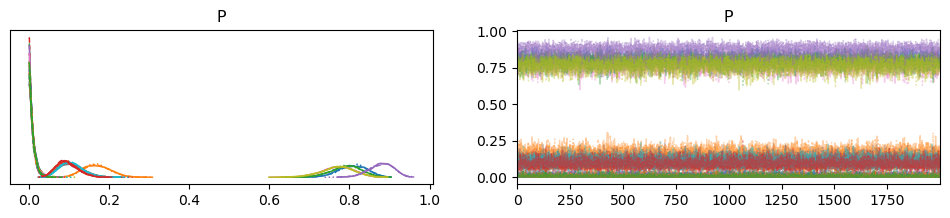

In [3]:
az.plot_trace(trace, var_names=["P"])
az.summary(trace, var_names=["P"])


In [4]:
P_mean = trace.posterior["P"].mean(dim=["chain", "draw"]).values


In [5]:
P_mean

array([[0.80790667, 0.16839449, 0.00797679, 0.00783492, 0.00788713],
       [0.10473953, 0.77186679, 0.10416426, 0.00967601, 0.00955341],
       [0.0087026 , 0.0960221 , 0.79177768, 0.09487471, 0.00862291],
       [0.0097432 , 0.00926757, 0.1053982 , 0.77042167, 0.10516936],
       [0.0086361 , 0.00881177, 0.00863954, 0.09527613, 0.87863646]])

array([[<Axes: title={'center': 'P'}>, <Axes: title={'center': 'P'}>]],
      dtype=object)

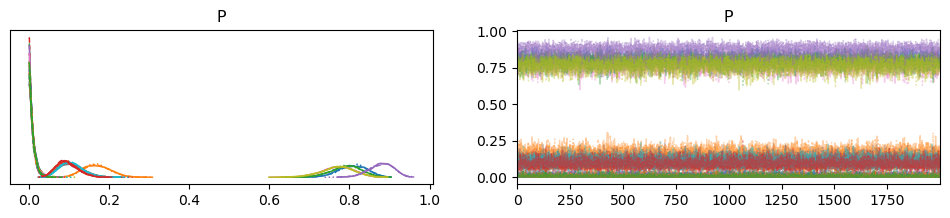

In [6]:
import arviz as az
az.plot_trace(trace)

/opt/anaconda3/lib/python3.11/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (25), generating only 20 plots
  warnings.warn(


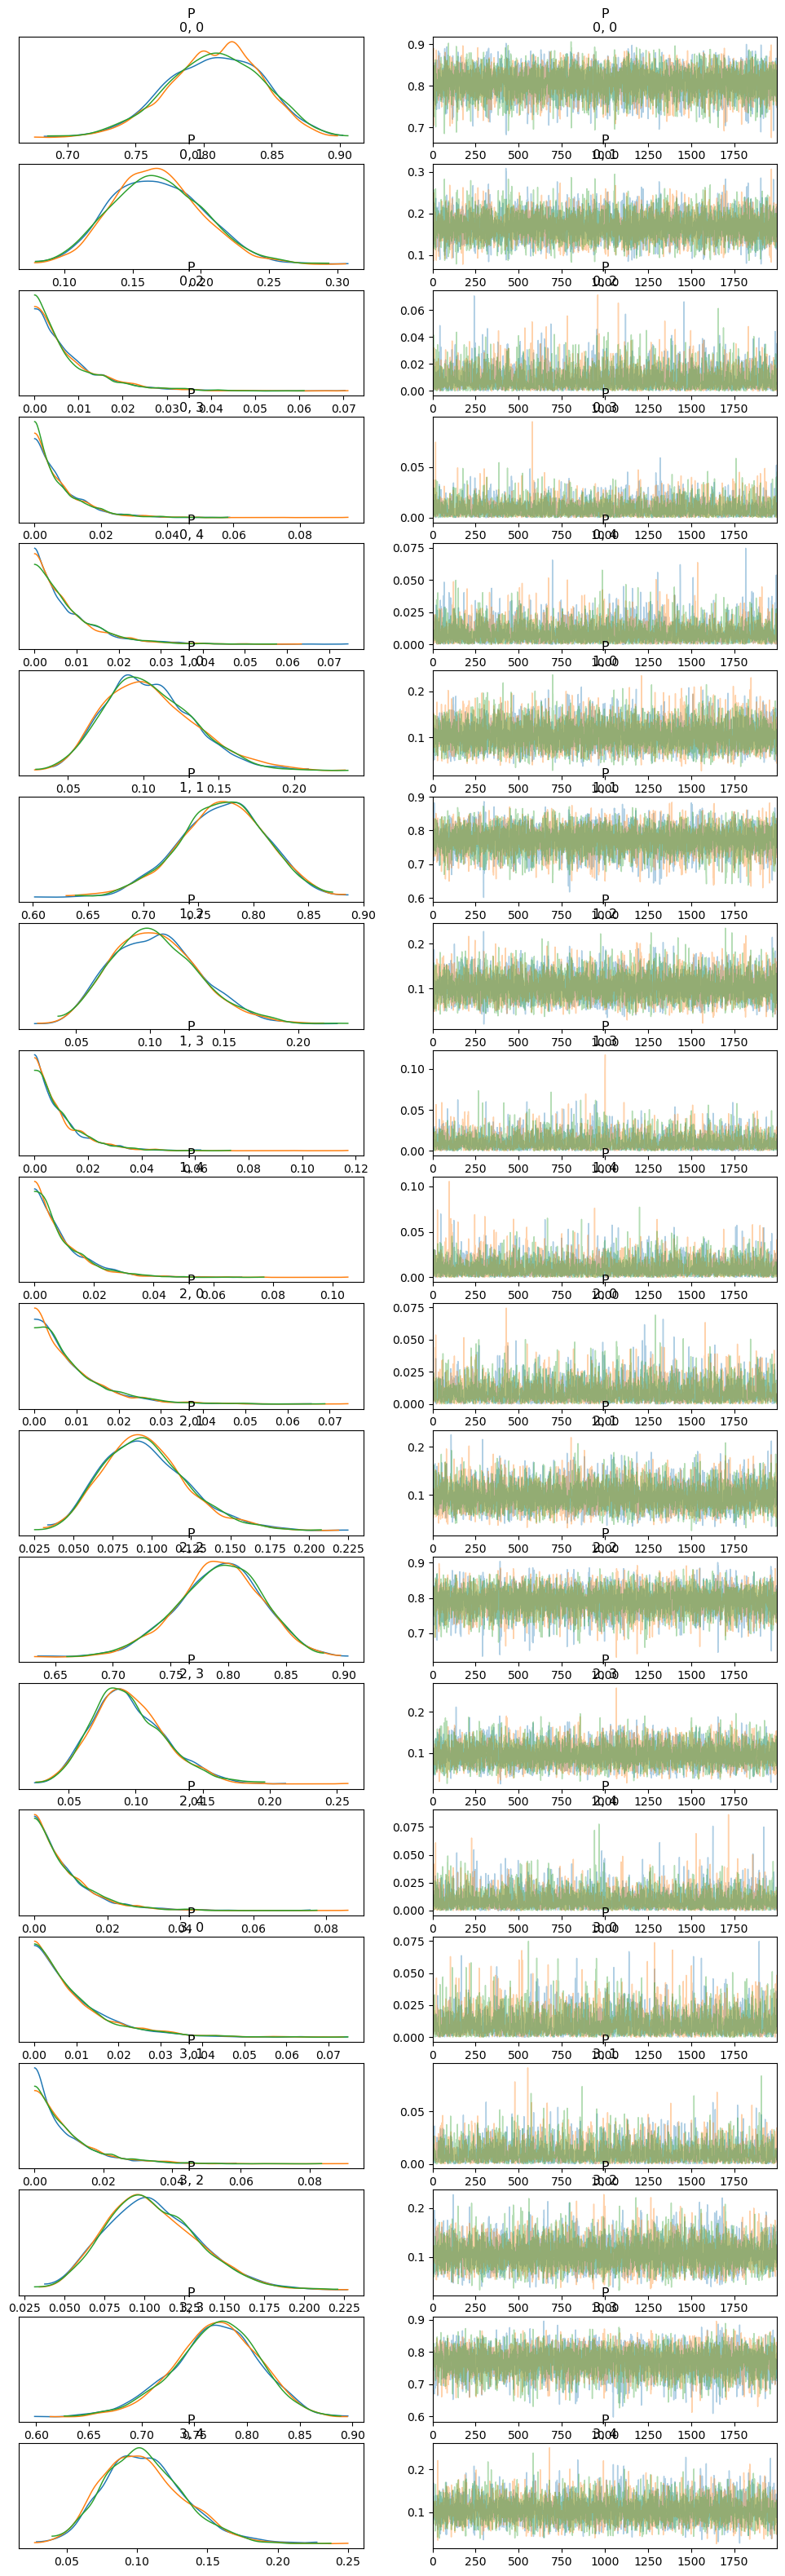

In [7]:
# Предположим, что trace — это результат работы pm.sample()
axes = az.plot_trace(trace, compact=False)

# Добавим легенду вручную к каждому подграфику
for ax_group in axes:
    for ax in ax_group:
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(handles, labels, title="Цепи", loc="best")

График для перехода: AAA → AAA


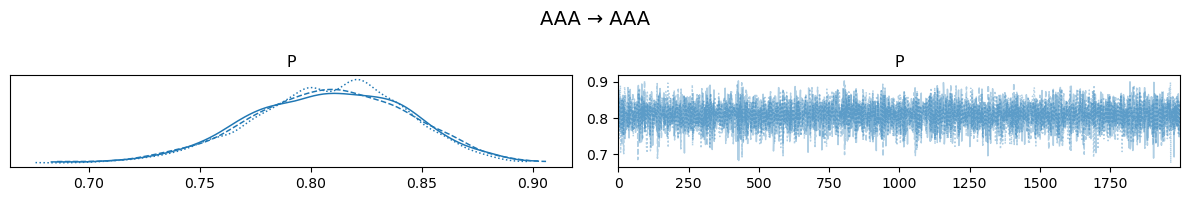

График для перехода: AAA → AA


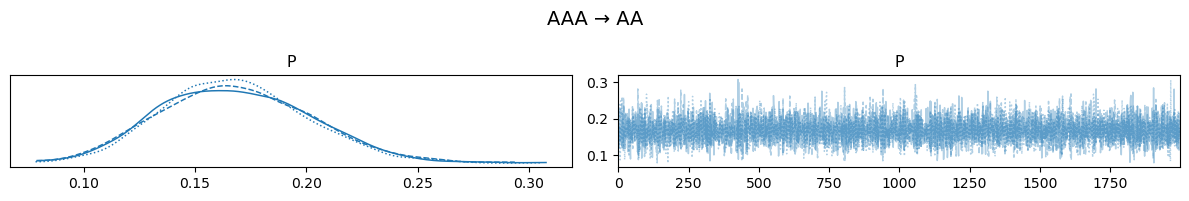

График для перехода: AAA → A


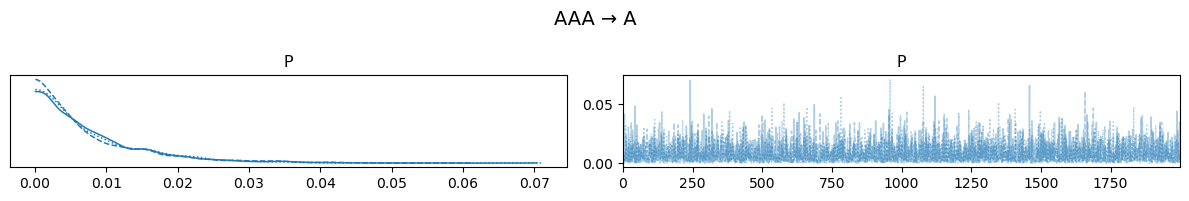

График для перехода: AAA → BBB


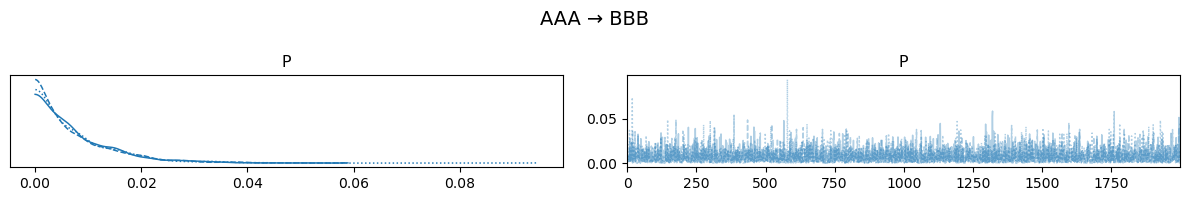

График для перехода: AAA → BB


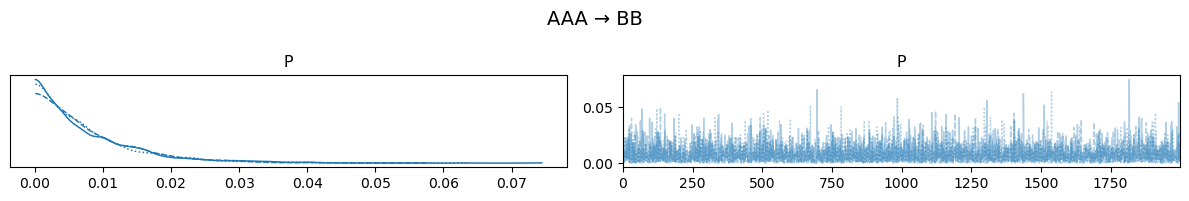

График для перехода: AAA → B


KeyError: 'Coords should follow mapping format {coord_name:[dim1, dim2]}. Check that coords structure is correct and dimensions are valid. "not all values found in index \'P_dim_1\'"'

In [8]:
import arviz as az
import matplotlib.pyplot as plt

# Названия рейтингов в нужном порядке (можно изменить под твои)
rating_names = ["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "D"]

# Размерность матрицы P (N x N)
n_ratings = len(rating_names)

# Перебираем все пары (i, j) и визуализируем каждый элемент P[i, j]
for i in range(n_ratings):
    for j in range(n_ratings):
        transition_label = f"{rating_names[i]} → {rating_names[j]}"
        print(f"График для перехода: {transition_label}")
        
        # Создаем отдельную фигуру для каждого перехода
        az.plot_trace(
            trace, 
            var_names=["P"], 
            coords={"P_dim_0": [i], "P_dim_1": [j]},
        )
        plt.suptitle(transition_label, fontsize=14)
        plt.tight_layout()
        plt.show()


In [ ]:
print(trace.posterior)


In [ ]:

# Визуализация трейсов всех переходов P[i, j]
for i in range(5):
    for j in range(5):
        transition_label = f"P[{i} → {j}]"
        print(f"График для перехода: {transition_label}")
        
        # Создаем фигуру и отображаем трейсы
        az.plot_trace(
            trace, 
            var_names=["P"], 
            coords={"P_dim_0": [i], "P_dim_1": [j]},
        )
        
        plt.suptitle(transition_label, fontsize=14)
        plt.tight_layout()
        plt.show()

In [ ]:
az.summary(trace, var_names=["P"], round_to=4)


Используя библиотеку emcee

In [15]:
pip install emcee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 585.6 kB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install  aesara


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
import emcee
import numpy as npv

In [66]:
# Пример: 3 рейтинга (A, B, C)
N = np.array([
    [50, 30, 20],  # из A: в A, B, C
    [10, 70, 20],  # из B: ...
    [5, 25, 70],   # из C: ...
])

from scipy.special import softmax
import emcee

def log_dirichlet_likelihood(logits, counts):
    probs = softmax(logits)
    if np.any(probs <= 0) or np.any(probs >= 1):
        return -np.inf
    # Мультиномиальное лог-правдоподобие
    return np.sum(counts * np.log(probs))
    
ndim = N.shape[1]
nwalkers = 10 * ndim
nsteps = 2000

matrix_estimates = []

for i in range(n_states):
    counts = N[i]
    initial_logits = np.random.randn(nwalkers, ndim)

    def log_prob(logits):
        return log_dirichlet_likelihood(logits, counts)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
    sampler.run_mcmc(initial_logits, nsteps, progress=True)

    samples = sampler.get_chain(discard=500, flat=True)
    prob_samples = softmax(samples, axis=1)
    mean_probs = np.mean(prob_samples, axis=0)
    matrix_estimates.append(mean_probs)


100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 455.62it/s]


In [32]:
P_est = np.array(matrix_estimates)
print("Оценённая матрица переходов:")
print(np.round(P_est, 3))


Оценённая матрица переходов:
[[0.352 0.329 0.32 ]
 [0.092 0.677 0.231]
 [0.035 0.259 0.705]]


Аналогично через pyMC

In [35]:
import numpy as np

# Пример: наблюдения переходов между 3 рейтингами
N = np.array([
    [50, 30, 20],   # из A
    [10, 70, 20],   # из B
    [5, 25, 70]     # из C
])


In [41]:
import pymc as pm
import aesara.tensor as at

n_states = N.shape[0]

with pm.Model() as model:
    # Для каждой строки — свои вероятности переходов
    P = pm.Dirichlet("P", a=np.ones((n_states, n_states)), shape=(n_states, n_states))
    
    # Модель наблюдаемых переходов (Multinomial по каждой строке)
    for i in range(n_states):
        pm.Multinomial(
            name=f"obs_{i}",
            n=N[i].sum(),
            p=P[i],
            observed=N[i]
        )

    trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)


Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 39 seconds.


array([[<Axes: title={'center': 'P\n0, 0'}>,
        <Axes: title={'center': 'P\n0, 1'}>,
        <Axes: title={'center': 'P\n0, 2'}>],
       [<Axes: title={'center': 'P\n1, 0'}>,
        <Axes: title={'center': 'P\n1, 1'}>,
        <Axes: title={'center': 'P\n1, 2'}>],
       [<Axes: title={'center': 'P\n2, 0'}>,
        <Axes: title={'center': 'P\n2, 1'}>,
        <Axes: title={'center': 'P\n2, 2'}>]], dtype=object)

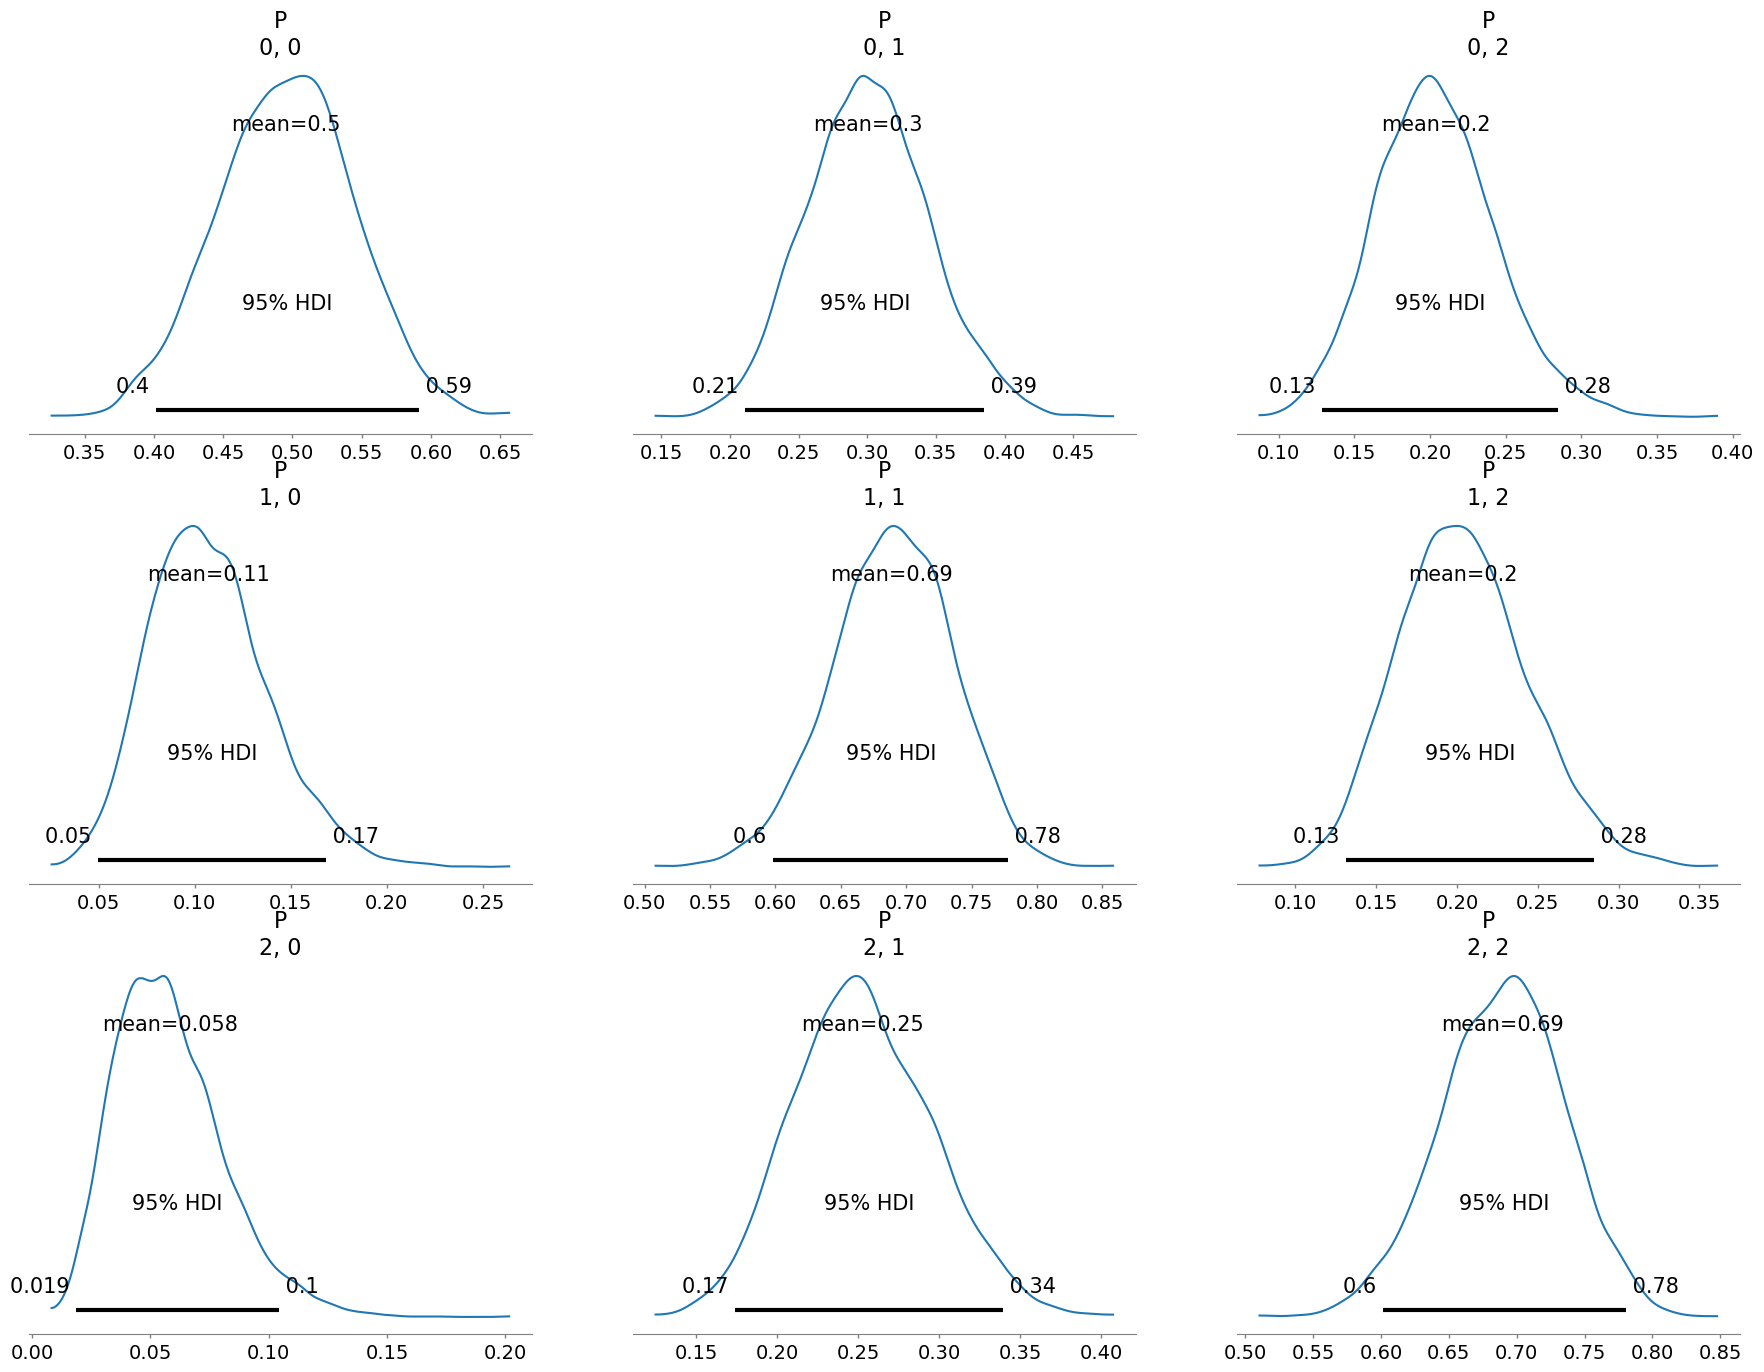

In [43]:
import arviz as az

# Графики апостериорных распределений вероятностей переходов
az.plot_posterior(trace, var_names=["P"], hdi_prob=0.95)


In [45]:
# Средняя оценка (по всем сэмплам)
mean_matrix = trace.posterior["P"].mean(dim=["chain", "draw"]).values
print("Оценённая матрица переходов:")
print(np.round(mean_matrix, 3))


Оценённая матрица переходов:
[[0.495 0.3   0.204]
 [0.107 0.689 0.204]
 [0.058 0.252 0.69 ]]


In [47]:
import pymc as pm
import numpy as np

# Пример данных
N = np.array([
    [50, 30, 20],
    [10, 70, 20],
    [5, 25, 70],
])
K = N.shape[0]

with pm.Model() as model:
    # A posteriori Dirichlet (аналитическое решение)
    P = pm.Dirichlet("P", a=1 + N, shape=N.shape)
    trace = pm.sample(2000, tune=1000, chains=3, target_accept=0.95)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [P]


Output()

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [49]:
import arviz as az
mean_matrix = trace.posterior["P"].mean(dim=["chain", "draw"]).values
print(np.round(mean_matrix, 3))

[[0.496 0.3   0.204]
 [0.107 0.69  0.203]
 [0.058 0.252 0.69 ]]


In [78]:
import numpy as np
import arviz as az
from scipy.stats import entropy

# Предполагаем, что у нас уже есть выборки (samples) по каждому элементу P[i,j]
# samples — словарь вида: {"P[0,0]": array([...]), ..., "P[2,2]": array([...])}

# Инициализация
n_states = 3
mean_matrix = np.zeros((n_states, n_states))
hpd_matrix = np.zeros((n_states, n_states, 2))
entropy_vector = np.zeros(n_states)

# Вычисление статистик
for i in range(n_states):
    row_samples = []
    for j in range(n_states):
        key = f"P[{i},{j}]"
        vals = samples[key]
        
        mean_matrix[i, j] = np.mean(vals)
        hpd_matrix[i, j] = az.hdi(vals, hdi_prob=0.95)
        row_samples.append(vals)
    
    # Вычисление энтропии по строке (по каждому сэмплу)
    row_stack = np.stack(row_samples, axis=1)
    row_entropy = entropy(row_stack.T, base=2)
    entropy_vector[i] = np.mean(row_entropy)

# Результаты
print("Средняя матрица переходов:\n", np.round(mean_matrix, 3))
print("\n95% HPD интервалы:")
for i in range(n_states):
    for j in range(n_states):
        print(f"P[{i},{j}]: {np.round(hpd_matrix[i, j, 0], 3)} — {np.round(hpd_matrix[i, j, 1], 3)}")

print("\nЭнтропия строк (в битах):", np.round(entropy_vector, 3))


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

еще раз с emcee для визуализации 

100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 438.03it/s]


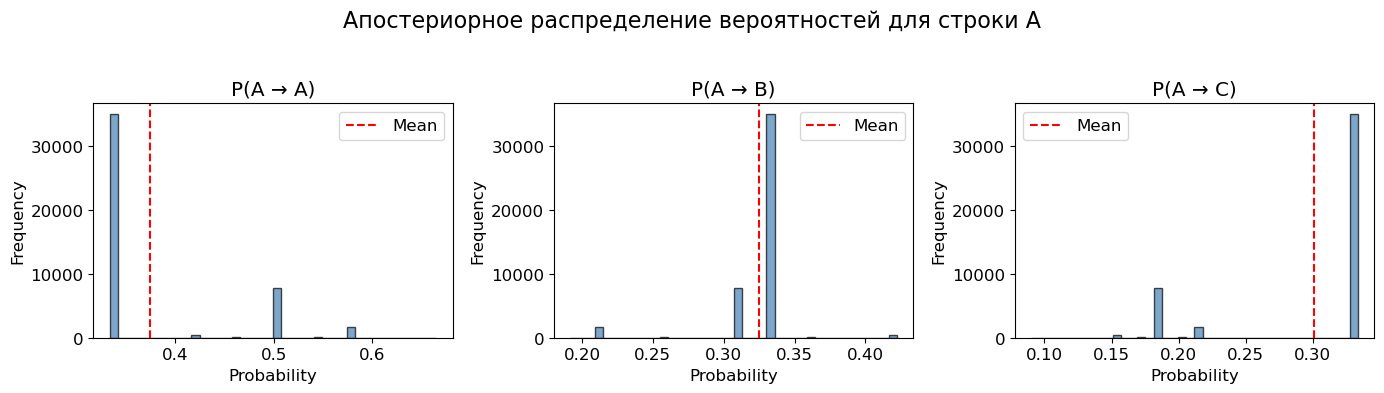

100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 449.05it/s]


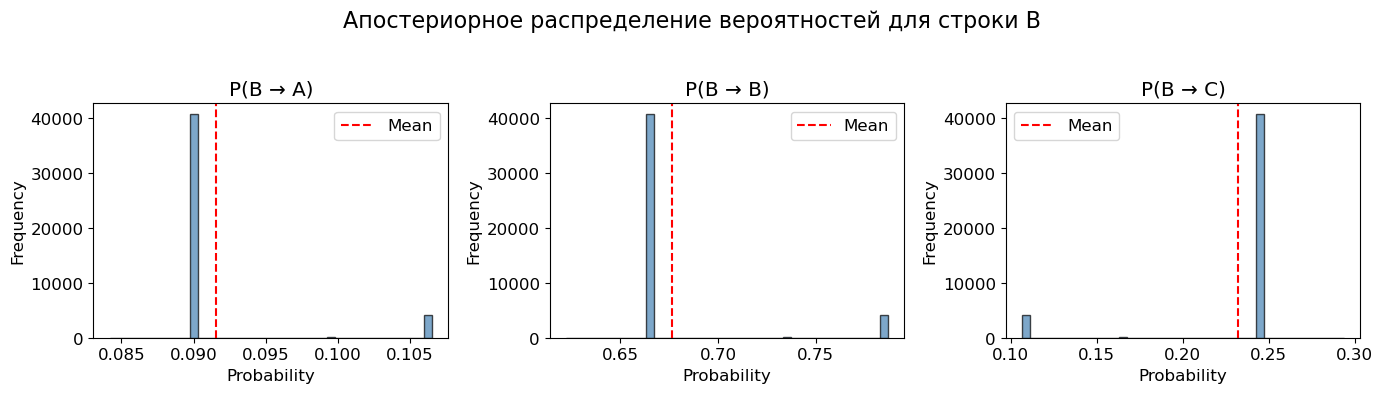

100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 446.82it/s]


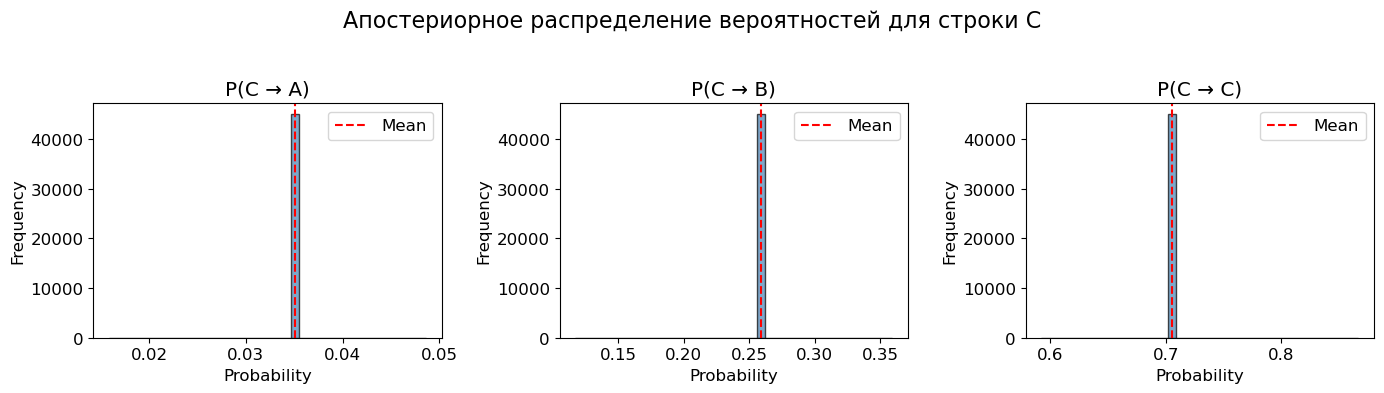

Оценённая матрица переходных вероятностей:
[[0.374 0.325 0.301]
 [0.092 0.677 0.232]
 [0.035 0.259 0.705]]


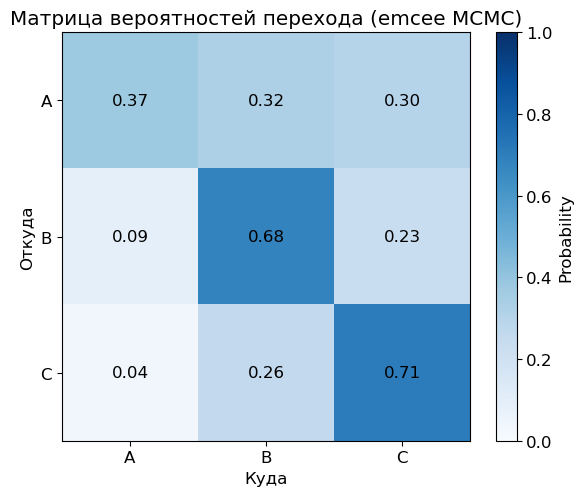

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import emcee

# Данные: матрица переходов между рейтингами
N = np.array([
    [50, 30, 20],  # из A: в A, B, C
    [10, 70, 20],
    [5, 25, 70],
])

n_states = N.shape[0]
ndim = N.shape[1]
nwalkers = 10 * ndim
nsteps = 2000

matrix_estimates = []

def log_dirichlet_likelihood(logits, counts):
    probs = softmax(logits, axis=-1)
    if np.any(probs <= 0) or np.any(probs >= 1):
        return -np.inf
    return np.sum(counts * np.log(probs + 1e-10))  # стабилизация

# Шрифт побольше для читаемости
plt.rcParams.update({'font.size': 12})

for i in range(n_states):
    counts = N[i]
    initial_logits = np.random.randn(nwalkers, ndim)

    def log_prob(logits):
        return log_dirichlet_likelihood(logits, counts)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
    sampler.run_mcmc(initial_logits, nsteps, progress=True)

    flat_samples = sampler.get_chain(discard=500, flat=True)
    prob_samples = softmax(flat_samples, axis=1)
    mean_probs = np.mean(prob_samples, axis=0)
    matrix_estimates.append(mean_probs)

    # ВИЗУАЛИЗАЦИЯ: Апостериорные распределения
    fig, axes = plt.subplots(1, ndim, figsize=(14, 4))
    for j in range(ndim):
        ax = axes[j]
        ax.hist(prob_samples[:, j], bins=40, color='steelblue', edgecolor='black', alpha=0.7)
        ax.set_title(f"P({chr(65+i)} → {chr(65+j)})")
        ax.set_xlabel("Probability")
        ax.set_ylabel("Frequency")
        ax.axvline(mean_probs[j], color='red', linestyle='--', label='Mean')
        ax.legend()
    fig.suptitle(f"Апостериорное распределение вероятностей для строки {chr(65+i)}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Финальная матрица
matrix_estimates = np.array(matrix_estimates)
print("Оценённая матрица переходных вероятностей:")
print(np.round(matrix_estimates, 3))

# Матрица как тепловая карта
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(matrix_estimates, cmap='Blues', vmin=0, vmax=1)

# Подписи
for i in range(n_states):
    for j in range(ndim):
        text = ax.text(j, i, f"{matrix_estimates[i, j]:.2f}",
                       ha="center", va="center", color="black")

ax.set_xticks(np.arange(ndim))
ax.set_yticks(np.arange(n_states))
ax.set_xticklabels([f"{chr(65+j)}" for j in range(ndim)])
ax.set_yticklabels([f"{chr(65+i)}" for i in range(n_states)])
ax.set_xlabel("Куда")
ax.set_ylabel("Откуда")
ax.set_title("Матрица вероятностей перехода (emcee MCMC)")
fig.colorbar(im, ax=ax, label="Probability")
plt.tight_layout()
plt.show()


Сделааем относительно наших данных

In [104]:
import pandas as pd
import numpy as np

def build_transition_matrix(df, agency_filter, ro_type_filter, rating_order):
    df = df[df["agency"] == agency_filter]
    df = df[df["_ro_type"] == ro_type_filter]
    df = df.sort_values(by=["identifier", "resampled_dates"])
    
    rating2idx = {r: i for i, r in enumerate(rating_order)}
    df["r_idx"] = df["rating_category"].map(rating2idx)
    
    df["next_r_idx"] = df.groupby("identifier")["r_idx"].shift(-1)
    transitions = df.dropna(subset=["r_idx", "next_r_idx"]).copy()
    transitions["r_idx"] = transitions["r_idx"].astype(int)
    transitions["next_r_idx"] = transitions["next_r_idx"].astype(int)
    
    n = len(rating_order)
    N = np.zeros((n, n), dtype=int)
    for _, row in transitions.iterrows():
        i, j = row["r_idx"], row["next_r_idx"]
        N[i, j] += 1
    
    return N, rating2idx


In [170]:
import pymc as pm
import arviz as az

def estimate_transition_matrix(N):
    n_states = N.shape[0]
    
    with pm.Model() as model:
        # Апостериорная матрица: каждая строка — вероятности переходов из одного рейтинга
        P = pm.Dirichlet("P", a=1. + N, shape=(n_states, n_states))
        
        # Ликелиход (по каждой строке): фиксируем наблюдаемые переходы
        for i in range(n_states):
            pm.Multinomial(name=f"obs_{i}", n=N[i].sum(), p=P[i], observed=N[i])
        
        trace = pm.sample(2000, tune=1000, chains=4, return_inferencedata=True, target_accept=0.8)
    
    return trace


In [172]:
def summarize_trace(trace, varname="P"):
    post = trace.posterior[varname]  # (chain, draw, i, j)
    mean_matrix = post.mean(dim=("chain", "draw")).values
    hdi_matrix = az.hdi(post, hdi_prob=0.95).values  # (i,j,2)
    
    return mean_matrix, hdi_matrix


In [101]:
import pandas as pd 

df = pd.read_excel("/Users/danilalipatov/PycharmProjects/diploma/resemple_data_cat_level_cat.xlsx")
print(df["rating_category"].unique())

['D' 'BBB' 'BBB-' 'A' 'A-' 'A+' 'AA-' 'BBB+' 'AAA' 'BB' 'AA+' 'AA' 'B'
 'B+' 'BB-' 'B-' 'CCC' 'CC' 'BB+' 'C']


In [174]:
# Подготовка
rating_order = [
    'AAA',
    'AA+',
    'AA',
    'AA-',
    'A+',
    'A',
    'A-',
    'BBB+',
    'BBB',
    'BBB-',
    'BB+',
    'BB',
    'BB-',
    'B+',
    'B',
    'B-',
    'CCC',
    'CC',
    'C',
    'D'
]
N, rating2idx = build_transition_matrix(df, agency_filter="Expert RA", ro_type_filter="CBNK - кредитная организация", rating_order=rating_order)

# Байесовская оценка
trace = estimate_transition_matrix(N)

# Результаты
mean_P, hdi_P = summarize_trace(trace)
print("Средняя матрица переходов:\n", np.round(mean_P, 3))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 290 seconds.


Средняя матрица переходов:
 [[0.968 0.004 0.004 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
  0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
 [0.002 0.968 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002
  0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002]
 [0.001 0.009 0.968 0.002 0.004 0.002 0.002 0.001 0.001 0.001 0.001 0.001
  0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
 [0.004 0.004 0.029 0.882 0.012 0.012 0.004 0.004 0.004 0.004 0.004 0.004
  0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004]
 [0.001 0.001 0.002 0.007 0.969 0.006 0.002 0.001 0.002 0.001 0.001 0.001
  0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
 [0.    0.    0.    0.001 0.011 0.966 0.005 0.008 0.001 0.001 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.001 0.    0.01  0.977 0.003 0.    0.002 0.    0.001
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.001 0.001 0.001 0.001 0.002 0.001 0.009 0.969 0.005 0.004 0.002 0.001
  0.001 0.001 0.001 0.001 

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 2000, P_dim_0: 20, P_dim_1: 20)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
  * P_dim_0  (P_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * P_dim_1  (P_dim_1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    P        (chain, draw, P_dim_0, P_dim_1) float64 0.972 0.00418 ... 0.9974
Attributes:
    created_at:                 2025-05-12T06:19:16.020000+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.22.0
    sampling_time:              289.89169907569885
    tuning_steps:               1000


/opt/anaconda3/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (400) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'P\n0, 0'}>,
        <Axes: title={'center': 'P\n0, 1'}>,
        <Axes: title={'center': 'P\n0, 2'}>,
        <Axes: title={'center': 'P\n0, 3'}>],
       [<Axes: title={'center': 'P\n0, 4'}>,
        <Axes: title={'center': 'P\n0, 5'}>,
        <Axes: title={'center': 'P\n0, 6'}>,
        <Axes: title={'center': 'P\n0, 7'}>],
       [<Axes: title={'center': 'P\n0, 8'}>,
        <Axes: title={'center': 'P\n0, 9'}>,
        <Axes: title={'center': 'P\n0, 10'}>,
        <Axes: title={'center': 'P\n0, 11'}>],
       [<Axes: title={'center': 'P\n0, 12'}>,
        <Axes: title={'center': 'P\n0, 13'}>,
        <Axes: title={'center': 'P\n0, 14'}>,
        <Axes: title={'center': 'P\n0, 15'}>],
       [<Axes: title={'center': 'P\n0, 16'}>,
        <Axes: title={'center': 'P\n0, 17'}>,
        <Axes: title={'center': 'P\n0, 18'}>,
        <Axes: title={'center': 'P\n0, 19'}>],
       [<Axes: title={'center': 'P\n1, 0'}>,
        <Axes: title={'center': 'P\n1, 1

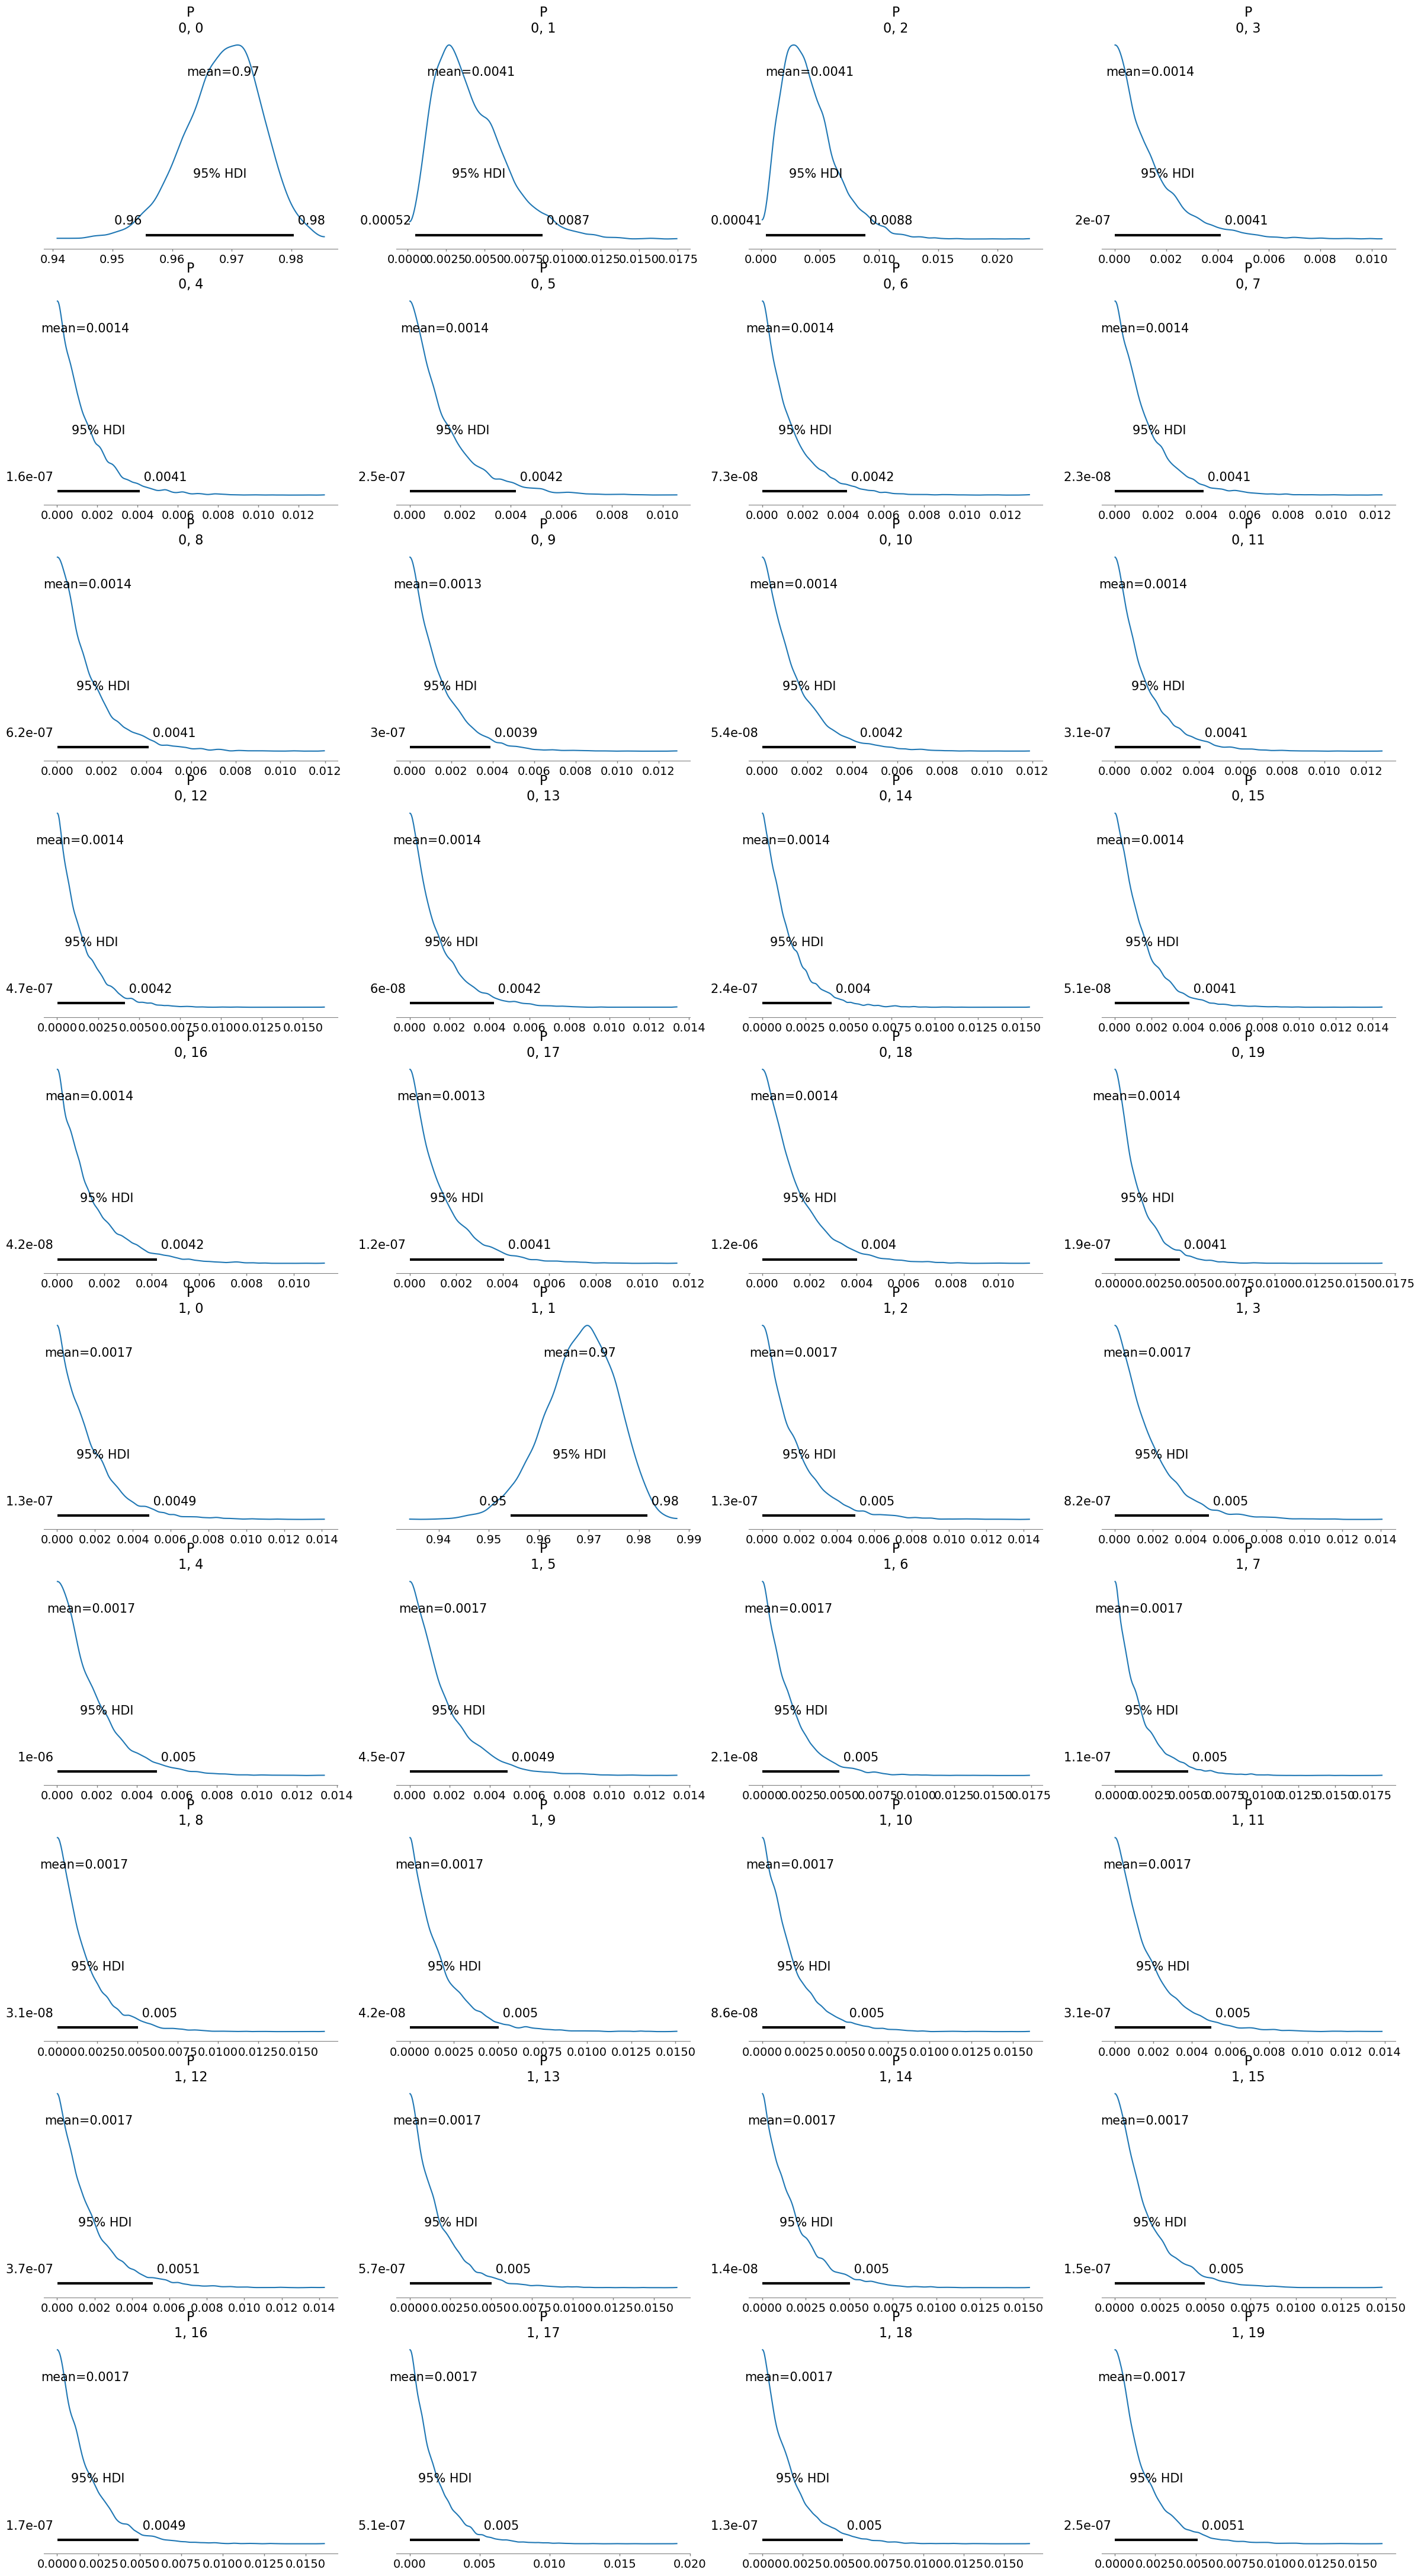

In [176]:
print(trace.posterior)
az.plot_posterior(trace, var_names=["P"], hdi_prob=0.95)

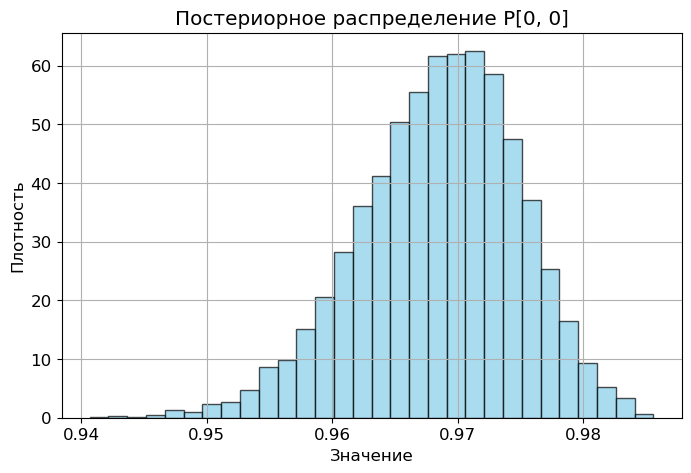

In [177]:
samples = trace.posterior["P"].sel(P_dim_0=0, P_dim_1=0).values.flatten()

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(samples, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.title("Апостериорное распределение P[0, 0]")
plt.xlabel("Значение")
plt.ylabel("Плотность")
plt.grid(True)
plt.show()

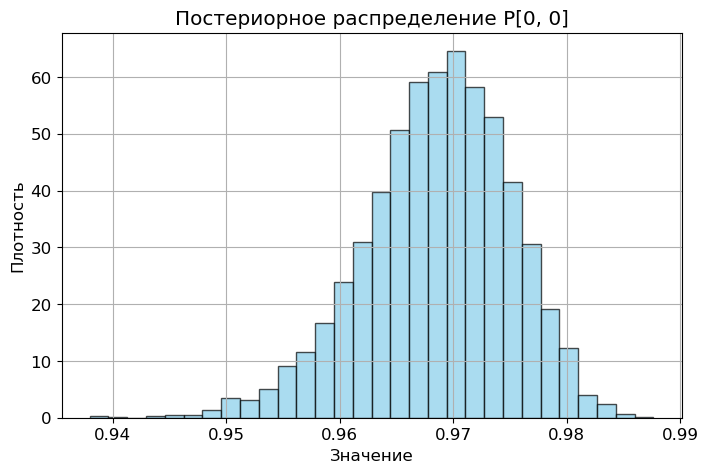

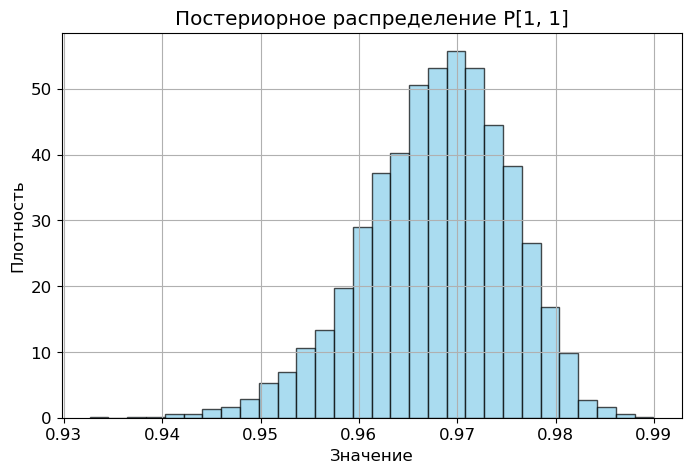

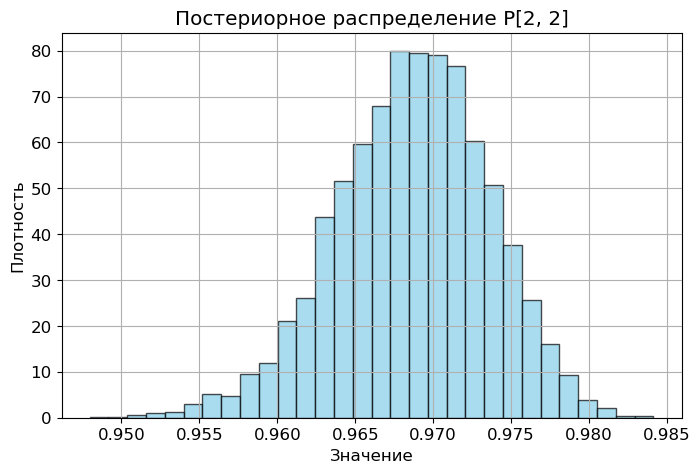

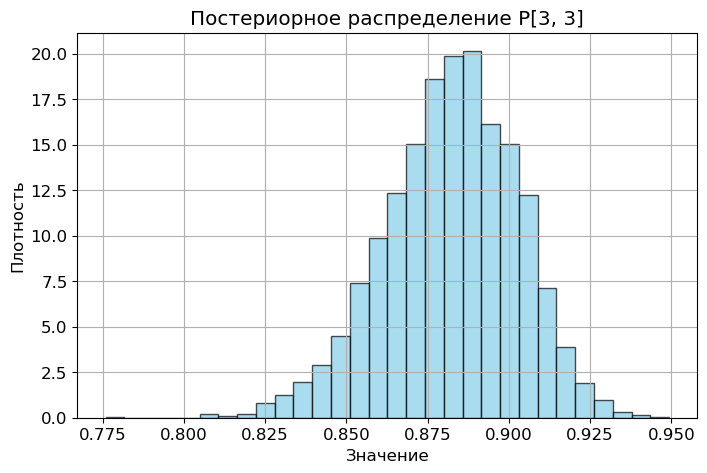

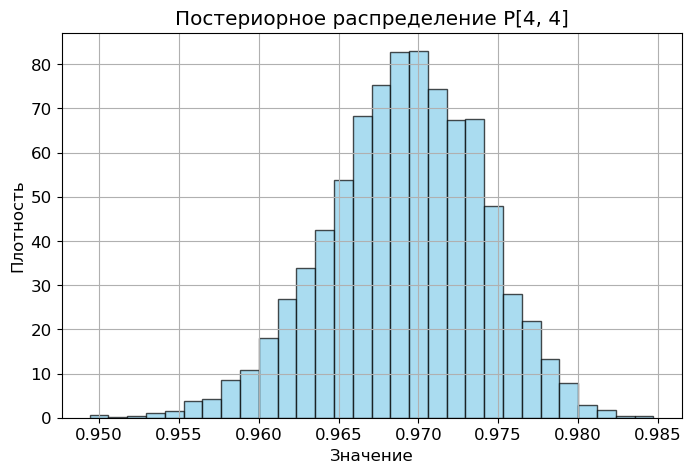

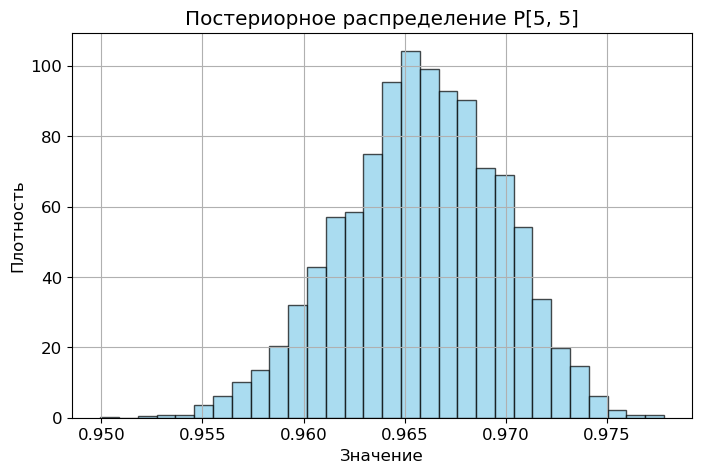

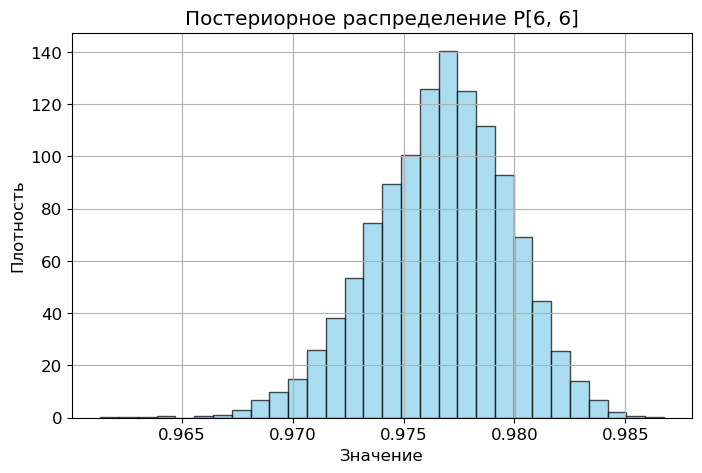

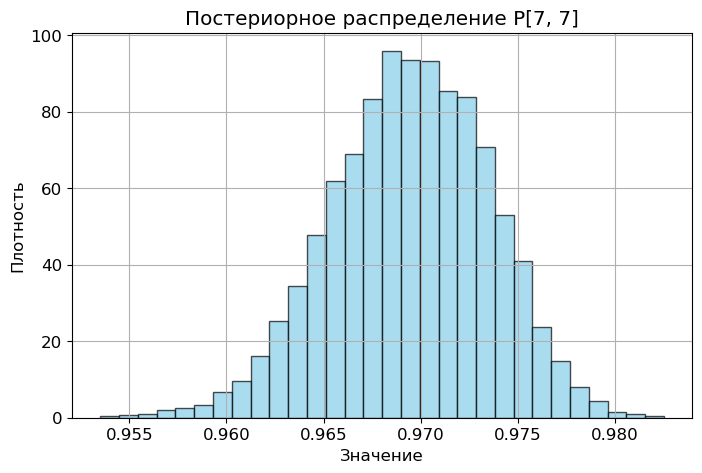

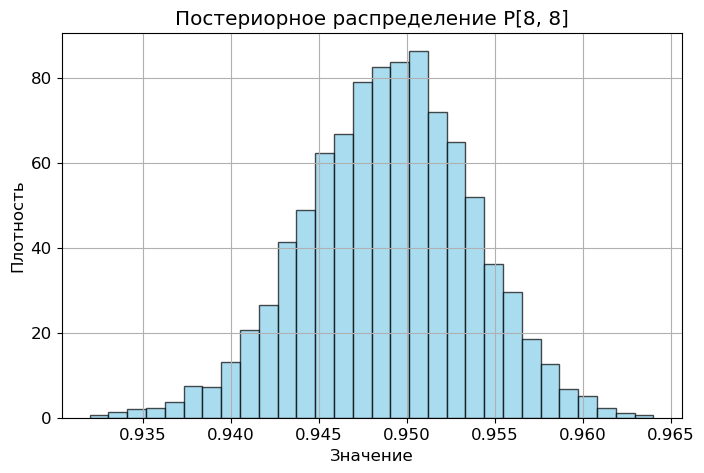

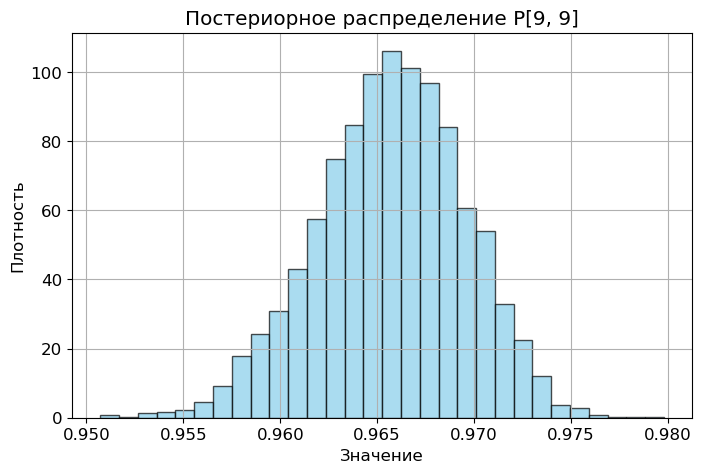

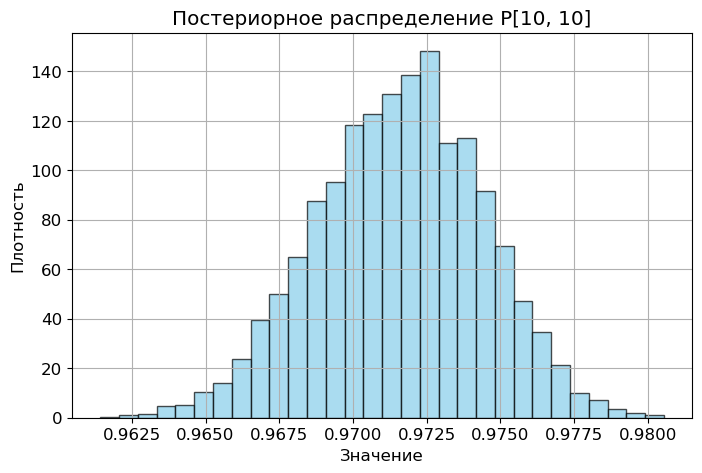

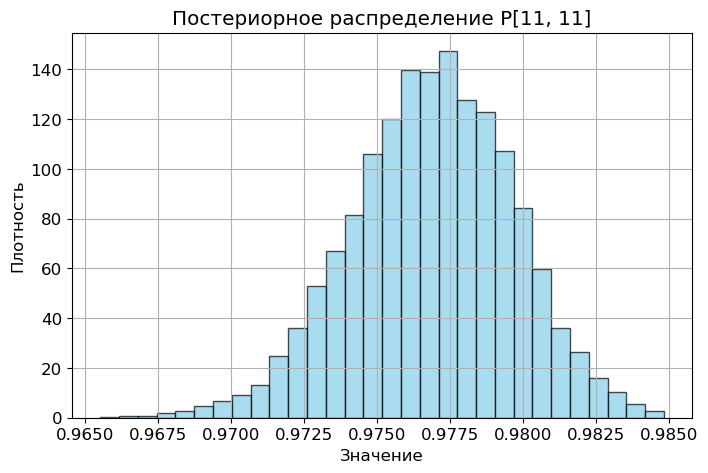

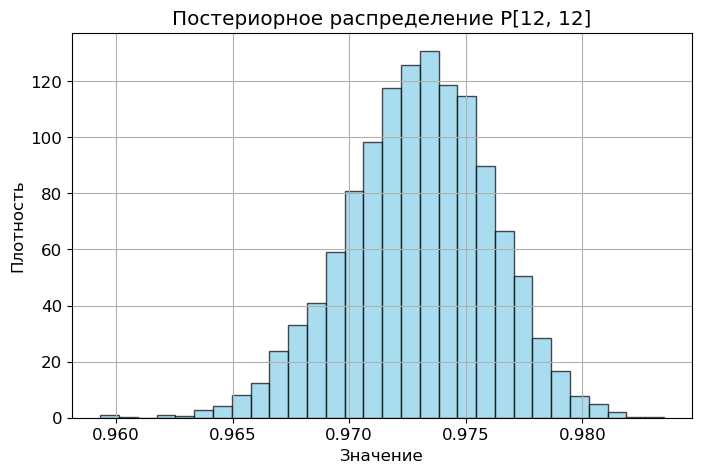

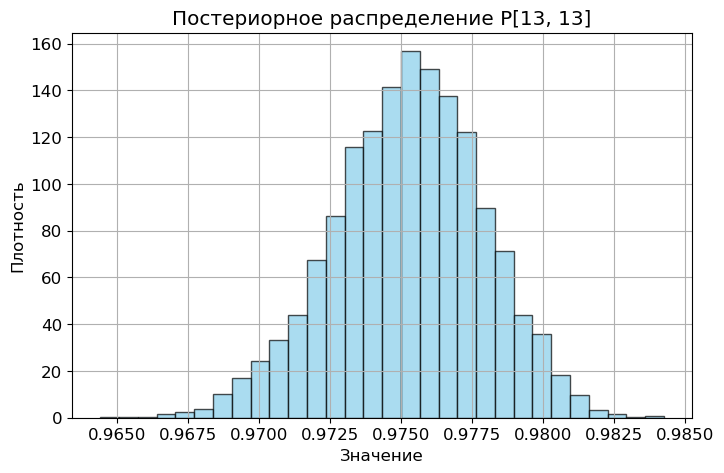

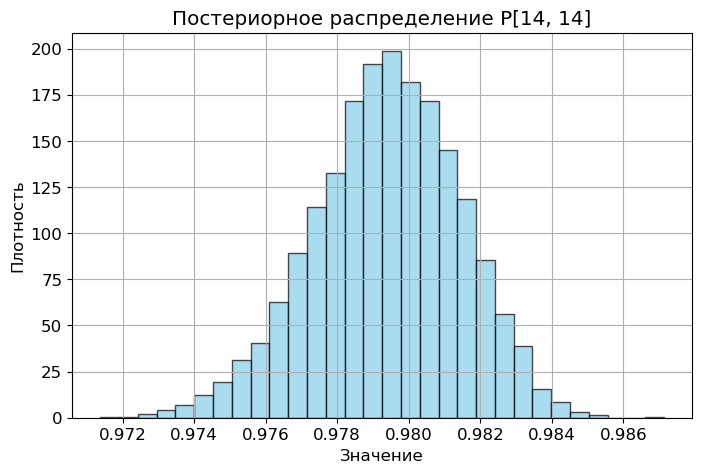

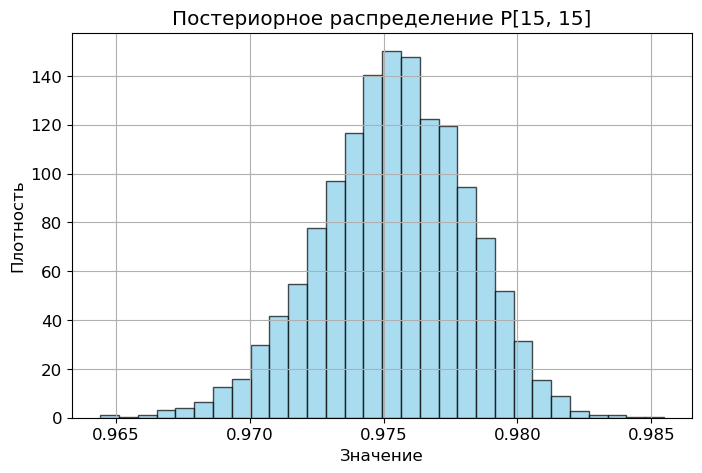

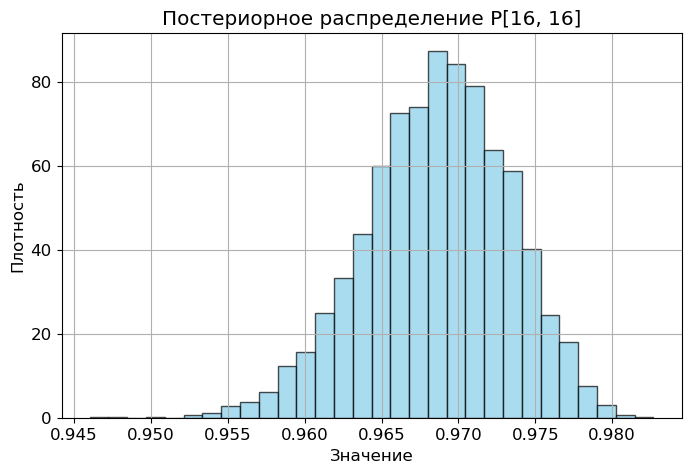

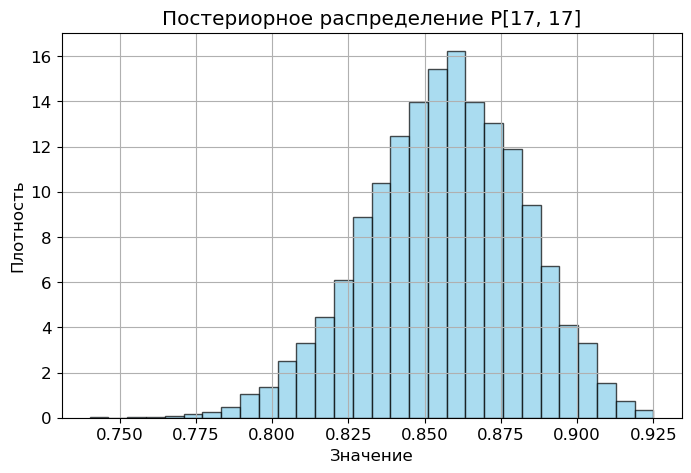

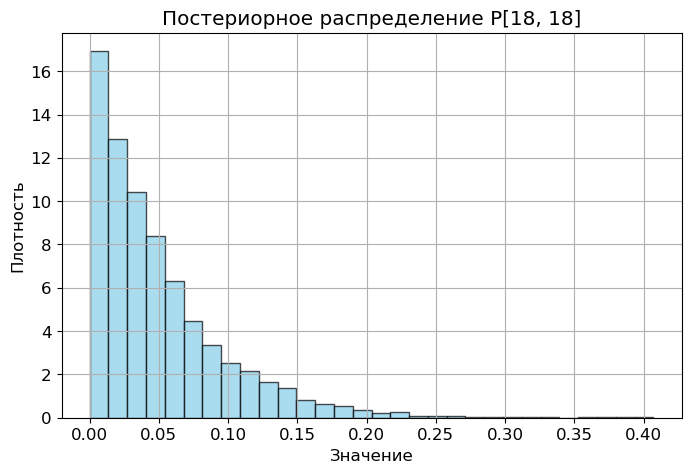

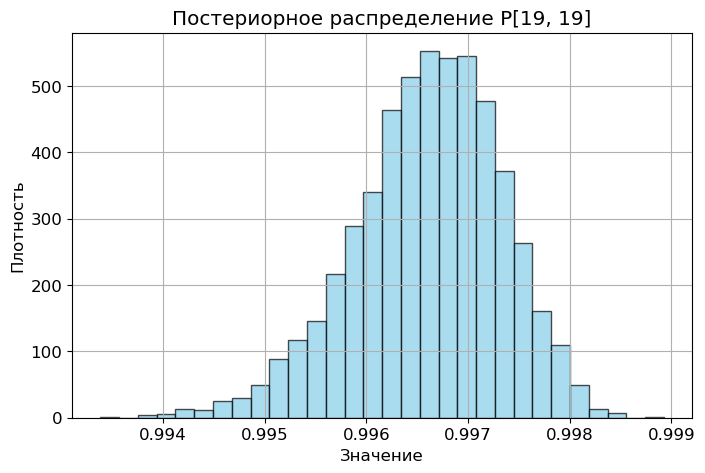

In [168]:
for i in range(0, 20):
    samples = trace.posterior["P"].sel(P_dim_0=i, P_dim_1=i).values.flatten()
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 5))
    plt.hist(samples, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f"Постериорное распределение P[{i}, {i}]")
    plt.xlabel("Значение")
    plt.ylabel("Плотность")
    plt.grid(True)
    plt.show()

Рассмотрим emcee на реальных данных

In [206]:
import pandas as pd
import numpy as np
from scipy.stats import dirichlet
from scipy.special import softmax
import emcee

# === Параметры ===
rating_order = [
    'AAA',
    'AA+',
    'AA',
    'AA-',
    'A+',
    'A',
    'A-',
    'BBB+',
    'BBB',
    'BBB-',
    'BB+',
    'BB',
    'BB-',
    'B+',
    'B',
    'B-',
    'CCC',
    'CC',
    'C',
    'D'
]
rating_to_idx = {r: i for i, r in enumerate(rating_order)}
n_states = len(rating_order)

def build_transition_counts(df, rating_to_idx, n_states):
    df = df.sort_values(['identifier', 'resampled_dates'])
    df['rating_idx'] = df['rating_category'].map(rating_to_idx)
    transitions = np.zeros((n_states, n_states), dtype=int)
    for _, group in df.groupby('identifier'):
        prev = group['rating_idx'].values[:-1]
        next_ = group['rating_idx'].values[1:]
        for i, j in zip(prev, next_):
            if np.isnan(i) or np.isnan(j): continue
            transitions[int(i), int(j)] += 1
    return transitions

def estimate_transition_matrix_emcee(N, n_states=20, steps=300):
    import warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    ndim = n_states * n_states
    n_walkers = 2 * ndim
    initial = 1e-2 * np.random.randn(n_walkers, ndim)

    # строка, где sum == 0, должны быть исключены из log_prob_fn
    rows_with_data = np.where(N.sum(axis=1) > 0)[0]
    rows_without_data = np.where(N.sum(axis=1) == 0)[0]

    def log_prob_fn(theta):
        P = theta.reshape((n_states, n_states))
        try:
            P = softmax(P, axis=1)
        except Exception:
            return -np.inf

        lp = 0.0
        for i in rows_with_data:
            alpha = N[i] + 1e-2
            if np.any(alpha <= 0):
                return -np.inf
            try:
                lp_i = dirichlet.logpdf(P[i], alpha=alpha)
                if not np.isfinite(lp_i):
                    return -np.inf
                lp += lp_i
            except Exception:
                return -np.inf
        return lp

    sampler = emcee.EnsembleSampler(n_walkers, ndim, log_prob_fn)
    sampler.run_mcmc(initial, steps, progress=True)

    samples_raw = sampler.get_chain(discard=min(500, steps // 2), thin=10, flat=True)
    samples_reshaped = samples_raw.reshape((-1, n_states, n_states))
    samples_softmaxed = np.apply_along_axis(softmax, 2, samples_reshaped)
    mean_matrix = samples_softmaxed.mean(axis=0)

    # Явно фиксируем строки без данных: вероятностная единица по диагонали
    for i in rows_without_data:
        mean_matrix[i] = np.zeros(n_states)
        mean_matrix[i, i] = 1.0

    # Обработка возможных NaN
    mean_matrix = np.nan_to_num(mean_matrix, nan=0.0)
    return mean_matrix, samples_softmaxed

In [208]:
# Выбираем фильтр
agency_filter="Expert RA"
ro_type_filter="CBNK - кредитная организация"

filtered_df = df[(df['agency'] == agency_filter) & (df['_ro_type'] == ro_type_filter)]

# Строим переходы
N = build_transition_counts(filtered_df, rating_to_idx, n_states)

# Байесовская оценка через emcee
mean_P, samples_P = estimate_transition_matrix_emcee(N, n_states=n_states)

# Вывод результатов
print("Оценённая матрица переходов:\n", np.round(mean_P, 3))


100%|█████████████████████████████████████████| 300/300 [06:36<00:00,  1.32s/it]


Оценённая матрица переходов:
 [[0.035 0.007 0.004 0.001 0.002 0.02  0.001 0.031 0.014 0.01  0.021 0.001
  0.01  0.003 0.001 0.003 0.364 0.018 0.449 0.004]
 [0.003 0.002 0.001 0.    0.    0.02  0.943 0.001 0.001 0.007 0.    0.001
  0.    0.003 0.002 0.008 0.001 0.002 0.002 0.001]
 [0.007 0.002 0.487 0.002 0.014 0.    0.004 0.    0.07  0.049 0.001 0.003
  0.026 0.023 0.007 0.003 0.062 0.011 0.    0.228]
 [0.001 0.04  0.    0.448 0.127 0.01  0.004 0.26  0.001 0.01  0.009 0.004
  0.    0.019 0.    0.031 0.014 0.004 0.004 0.015]
 [0.046 0.12  0.058 0.004 0.136 0.118 0.017 0.067 0.093 0.004 0.031 0.026
  0.001 0.042 0.004 0.156 0.016 0.037 0.001 0.023]
 [0.006 0.007 0.017 0.099 0.011 0.517 0.022 0.108 0.016 0.022 0.031 0.001
  0.023 0.001 0.011 0.004 0.08  0.002 0.011 0.012]
 [0.021 0.069 0.029 0.033 0.036 0.015 0.255 0.207 0.016 0.002 0.12  0.026
  0.027 0.001 0.036 0.012 0.023 0.004 0.044 0.025]
 [0.078 0.068 0.513 0.002 0.01  0.003 0.021 0.125 0.016 0.041 0.011 0.001
  0.007 0.034 0.019 0

In [204]:
N

array([[ 354,    1,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  288,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    5,  601,    1,    2,    1,    1,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    3,  108,    1,    1,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    1,    4,  611,    3,    1,    0,    1,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    1,   12, 1057,    5,    8,    1,    1,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    1,    0,   11, 1151,    3,    0,    2,    0,
           1,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    1,    

In [142]:
import matplotlib.pyplot as plt
import numpy as np

# Извлекаем массив из posterior
samples = trace.posterior["P"].values  # shape: (chain, draw, P_dim_0, P_dim_1)

# Объединяем цепочки и итерации в одну ось
samples = samples.reshape(-1, 20, 20)  # теперь: (chain * draw, 20, 20)

# График
fig, axes = plt.subplots(20, 20, figsize=(20, 20), sharex=True, sharey=True)
fig.suptitle("Постериорные распределения P[i, j]", fontsize=16)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Построение гистограмм
for i in range(20):
    for j in range(20):
        ax = axes[i, j]
        ax.hist(samples[:, i, j], bins=20, color='skyblue', alpha=0.8, edgecolor='black', density=True)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 19:
            ax.set_xlabel(f'{j}')
        if j == 0:
            ax.set_ylabel(f'{i}')

# Сохраняем
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("posterior_matrix_histograms.png", dpi=300)
# plt.close()


In [126]:
import arviz as az
import numpy as np

# Шаг 1: Байесовская оценка матрицы переходов
# trace = estimate_transition_matrix(N)  # Это ваша функция, которая генерирует trace

# Шаг 2: Подведение итогов, например, средняя матрица переходов
mean_P, hdi_P = summarize_trace(trace)  # Функция для подведения итогов (например, усреднение)

print("Средняя матрица переходов:\n", np.round(mean_P, 3))

# Шаг 3: Визуализация апостериорных распределений для всех переходов P[i,j]
# Визуализируем переходы между состояниями для каждого P[i,j]

# Если матрица P имеет размерность (n_states, n_states):
n_states = mean_P.shape[0]

# Генерация графиков для всех переходов
var_names = [f"P[{i},{j}]" for i in range(n_states) for j in range(n_states)]

# Визуализация
az.plot_posterior(trace, var_names=var_names, hdi_prob=0.95)

# Примечание:
# Это отобразит графики распределений для каждой вероятности P[i,j] с 95% интервалом HDI


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [P]


Output()

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 229 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Средняя матрица переходов:
 [[0.992 0.    0.002 0.    0.    0.001 0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.021 0.956 0.001 0.003 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
  0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
 [0.001 0.007 0.979 0.005 0.001 0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.003 0.002 0.01  0.969 0.006 0.003 0.001 0.001 0.001 0.001 0.001 0.001
  0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
 [0.    0.    0.005 0.011 0.965 0.009 0.002 0.    0.    0.003 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.001 0.014 0.973 0.002 0.002 0.002 0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.001 0.004 0.006 0.98  0.003 0.002 0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.01  0.978 0.004 0.001 0.    0.001
  0.    0.    0.    0.    0.    0.    

KeyError: 'var names: "[\'P[0,0]\' \'P[0,1]\' \'P[0,2]\' \'P[0,3]\' \'P[0,4]\' \'P[0,5]\' \'P[0,6]\' \'P[0,7]\'\\n \'P[0,8]\' \'P[0,9]\' \'P[0,10]\' \'P[0,11]\' \'P[0,12]\' \'P[0,13]\' \'P[0,14]\'\\n \'P[0,15]\' \'P[0,16]\' \'P[0,17]\' \'P[0,18]\' \'P[0,19]\' \'P[1,0]\' \'P[1,1]\'\\n \'P[1,2]\' \'P[1,3]\' \'P[1,4]\' \'P[1,5]\' \'P[1,6]\' \'P[1,7]\' \'P[1,8]\' \'P[1,9]\'\\n \'P[1,10]\' \'P[1,11]\' \'P[1,12]\' \'P[1,13]\' \'P[1,14]\' \'P[1,15]\' \'P[1,16]\'\\n \'P[1,17]\' \'P[1,18]\' \'P[1,19]\' \'P[2,0]\' \'P[2,1]\' \'P[2,2]\' \'P[2,3]\'\\n \'P[2,4]\' \'P[2,5]\' \'P[2,6]\' \'P[2,7]\' \'P[2,8]\' \'P[2,9]\' \'P[2,10]\' \'P[2,11]\'\\n \'P[2,12]\' \'P[2,13]\' \'P[2,14]\' \'P[2,15]\' \'P[2,16]\' \'P[2,17]\' \'P[2,18]\'\\n \'P[2,19]\' \'P[3,0]\' \'P[3,1]\' \'P[3,2]\' \'P[3,3]\' \'P[3,4]\' \'P[3,5]\' \'P[3,6]\'\\n \'P[3,7]\' \'P[3,8]\' \'P[3,9]\' \'P[3,10]\' \'P[3,11]\' \'P[3,12]\' \'P[3,13]\'\\n \'P[3,14]\' \'P[3,15]\' \'P[3,16]\' \'P[3,17]\' \'P[3,18]\' \'P[3,19]\' \'P[4,0]\'\\n \'P[4,1]\' \'P[4,2]\' \'P[4,3]\' \'P[4,4]\' \'P[4,5]\' \'P[4,6]\' \'P[4,7]\' \'P[4,8]\'\\n \'P[4,9]\' \'P[4,10]\' \'P[4,11]\' \'P[4,12]\' \'P[4,13]\' \'P[4,14]\' \'P[4,15]\'\\n \'P[4,16]\' \'P[4,17]\' \'P[4,18]\' \'P[4,19]\' \'P[5,0]\' \'P[5,1]\' \'P[5,2]\'\\n \'P[5,3]\' \'P[5,4]\' \'P[5,5]\' \'P[5,6]\' \'P[5,7]\' \'P[5,8]\' \'P[5,9]\' \'P[5,10]\'\\n \'P[5,11]\' \'P[5,12]\' \'P[5,13]\' \'P[5,14]\' \'P[5,15]\' \'P[5,16]\' \'P[5,17]\'\\n \'P[5,18]\' \'P[5,19]\' \'P[6,0]\' \'P[6,1]\' \'P[6,2]\' \'P[6,3]\' \'P[6,4]\' \'P[6,5]\'\\n \'P[6,6]\' \'P[6,7]\' \'P[6,8]\' \'P[6,9]\' \'P[6,10]\' \'P[6,11]\' \'P[6,12]\'\\n \'P[6,13]\' \'P[6,14]\' \'P[6,15]\' \'P[6,16]\' \'P[6,17]\' \'P[6,18]\' \'P[6,19]\'\\n \'P[7,0]\' \'P[7,1]\' \'P[7,2]\' \'P[7,3]\' \'P[7,4]\' \'P[7,5]\' \'P[7,6]\' \'P[7,7]\'\\n \'P[7,8]\' \'P[7,9]\' \'P[7,10]\' \'P[7,11]\' \'P[7,12]\' \'P[7,13]\' \'P[7,14]\'\\n \'P[7,15]\' \'P[7,16]\' \'P[7,17]\' \'P[7,18]\' \'P[7,19]\' \'P[8,0]\' \'P[8,1]\'\\n \'P[8,2]\' \'P[8,3]\' \'P[8,4]\' \'P[8,5]\' \'P[8,6]\' \'P[8,7]\' \'P[8,8]\' \'P[8,9]\'\\n \'P[8,10]\' \'P[8,11]\' \'P[8,12]\' \'P[8,13]\' \'P[8,14]\' \'P[8,15]\' \'P[8,16]\'\\n \'P[8,17]\' \'P[8,18]\' \'P[8,19]\' \'P[9,0]\' \'P[9,1]\' \'P[9,2]\' \'P[9,3]\'\\n \'P[9,4]\' \'P[9,5]\' \'P[9,6]\' \'P[9,7]\' \'P[9,8]\' \'P[9,9]\' \'P[9,10]\' \'P[9,11]\'\\n \'P[9,12]\' \'P[9,13]\' \'P[9,14]\' \'P[9,15]\' \'P[9,16]\' \'P[9,17]\' \'P[9,18]\'\\n \'P[9,19]\' \'P[10,0]\' \'P[10,1]\' \'P[10,2]\' \'P[10,3]\' \'P[10,4]\' \'P[10,5]\'\\n \'P[10,6]\' \'P[10,7]\' \'P[10,8]\' \'P[10,9]\' \'P[10,10]\' \'P[10,11]\' \'P[10,12]\'\\n \'P[10,13]\' \'P[10,14]\' \'P[10,15]\' \'P[10,16]\' \'P[10,17]\' \'P[10,18]\'\\n \'P[10,19]\' \'P[11,0]\' \'P[11,1]\' \'P[11,2]\' \'P[11,3]\' \'P[11,4]\' \'P[11,5]\'\\n \'P[11,6]\' \'P[11,7]\' \'P[11,8]\' \'P[11,9]\' \'P[11,10]\' \'P[11,11]\' \'P[11,12]\'\\n \'P[11,13]\' \'P[11,14]\' \'P[11,15]\' \'P[11,16]\' \'P[11,17]\' \'P[11,18]\'\\n \'P[11,19]\' \'P[12,0]\' \'P[12,1]\' \'P[12,2]\' \'P[12,3]\' \'P[12,4]\' \'P[12,5]\'\\n \'P[12,6]\' \'P[12,7]\' \'P[12,8]\' \'P[12,9]\' \'P[12,10]\' \'P[12,11]\' \'P[12,12]\'\\n \'P[12,13]\' \'P[12,14]\' \'P[12,15]\' \'P[12,16]\' \'P[12,17]\' \'P[12,18]\'\\n \'P[12,19]\' \'P[13,0]\' \'P[13,1]\' \'P[13,2]\' \'P[13,3]\' \'P[13,4]\' \'P[13,5]\'\\n \'P[13,6]\' \'P[13,7]\' \'P[13,8]\' \'P[13,9]\' \'P[13,10]\' \'P[13,11]\' \'P[13,12]\'\\n \'P[13,13]\' \'P[13,14]\' \'P[13,15]\' \'P[13,16]\' \'P[13,17]\' \'P[13,18]\'\\n \'P[13,19]\' \'P[14,0]\' \'P[14,1]\' \'P[14,2]\' \'P[14,3]\' \'P[14,4]\' \'P[14,5]\'\\n \'P[14,6]\' \'P[14,7]\' \'P[14,8]\' \'P[14,9]\' \'P[14,10]\' \'P[14,11]\' \'P[14,12]\'\\n \'P[14,13]\' \'P[14,14]\' \'P[14,15]\' \'P[14,16]\' \'P[14,17]\' \'P[14,18]\'\\n \'P[14,19]\' \'P[15,0]\' \'P[15,1]\' \'P[15,2]\' \'P[15,3]\' \'P[15,4]\' \'P[15,5]\'\\n \'P[15,6]\' \'P[15,7]\' \'P[15,8]\' \'P[15,9]\' \'P[15,10]\' \'P[15,11]\' \'P[15,12]\'\\n \'P[15,13]\' \'P[15,14]\' \'P[15,15]\' \'P[15,16]\' \'P[15,17]\' \'P[15,18]\'\\n \'P[15,19]\' \'P[16,0]\' \'P[16,1]\' \'P[16,2]\' \'P[16,3]\' \'P[16,4]\' \'P[16,5]\'\\n \'P[16,6]\' \'P[16,7]\' \'P[16,8]\' \'P[16,9]\' \'P[16,10]\' \'P[16,11]\' \'P[16,12]\'\\n \'P[16,13]\' \'P[16,14]\' \'P[16,15]\' \'P[16,16]\' \'P[16,17]\' \'P[16,18]\'\\n \'P[16,19]\' \'P[17,0]\' \'P[17,1]\' \'P[17,2]\' \'P[17,3]\' \'P[17,4]\' \'P[17,5]\'\\n \'P[17,6]\' \'P[17,7]\' \'P[17,8]\' \'P[17,9]\' \'P[17,10]\' \'P[17,11]\' \'P[17,12]\'\\n \'P[17,13]\' \'P[17,14]\' \'P[17,15]\' \'P[17,16]\' \'P[17,17]\' \'P[17,18]\'\\n \'P[17,19]\' \'P[18,0]\' \'P[18,1]\' \'P[18,2]\' \'P[18,3]\' \'P[18,4]\' \'P[18,5]\'\\n \'P[18,6]\' \'P[18,7]\' \'P[18,8]\' \'P[18,9]\' \'P[18,10]\' \'P[18,11]\' \'P[18,12]\'\\n \'P[18,13]\' \'P[18,14]\' \'P[18,15]\' \'P[18,16]\' \'P[18,17]\' \'P[18,18]\'\\n \'P[18,19]\' \'P[19,0]\' \'P[19,1]\' \'P[19,2]\' \'P[19,3]\' \'P[19,4]\' \'P[19,5]\'\\n \'P[19,6]\' \'P[19,7]\' \'P[19,8]\' \'P[19,9]\' \'P[19,10]\' \'P[19,11]\' \'P[19,12]\'\\n \'P[19,13]\' \'P[19,14]\' \'P[19,15]\' \'P[19,16]\' \'P[19,17]\' \'P[19,18]\'\\n \'P[19,19]\'] are not present" in dataset'

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

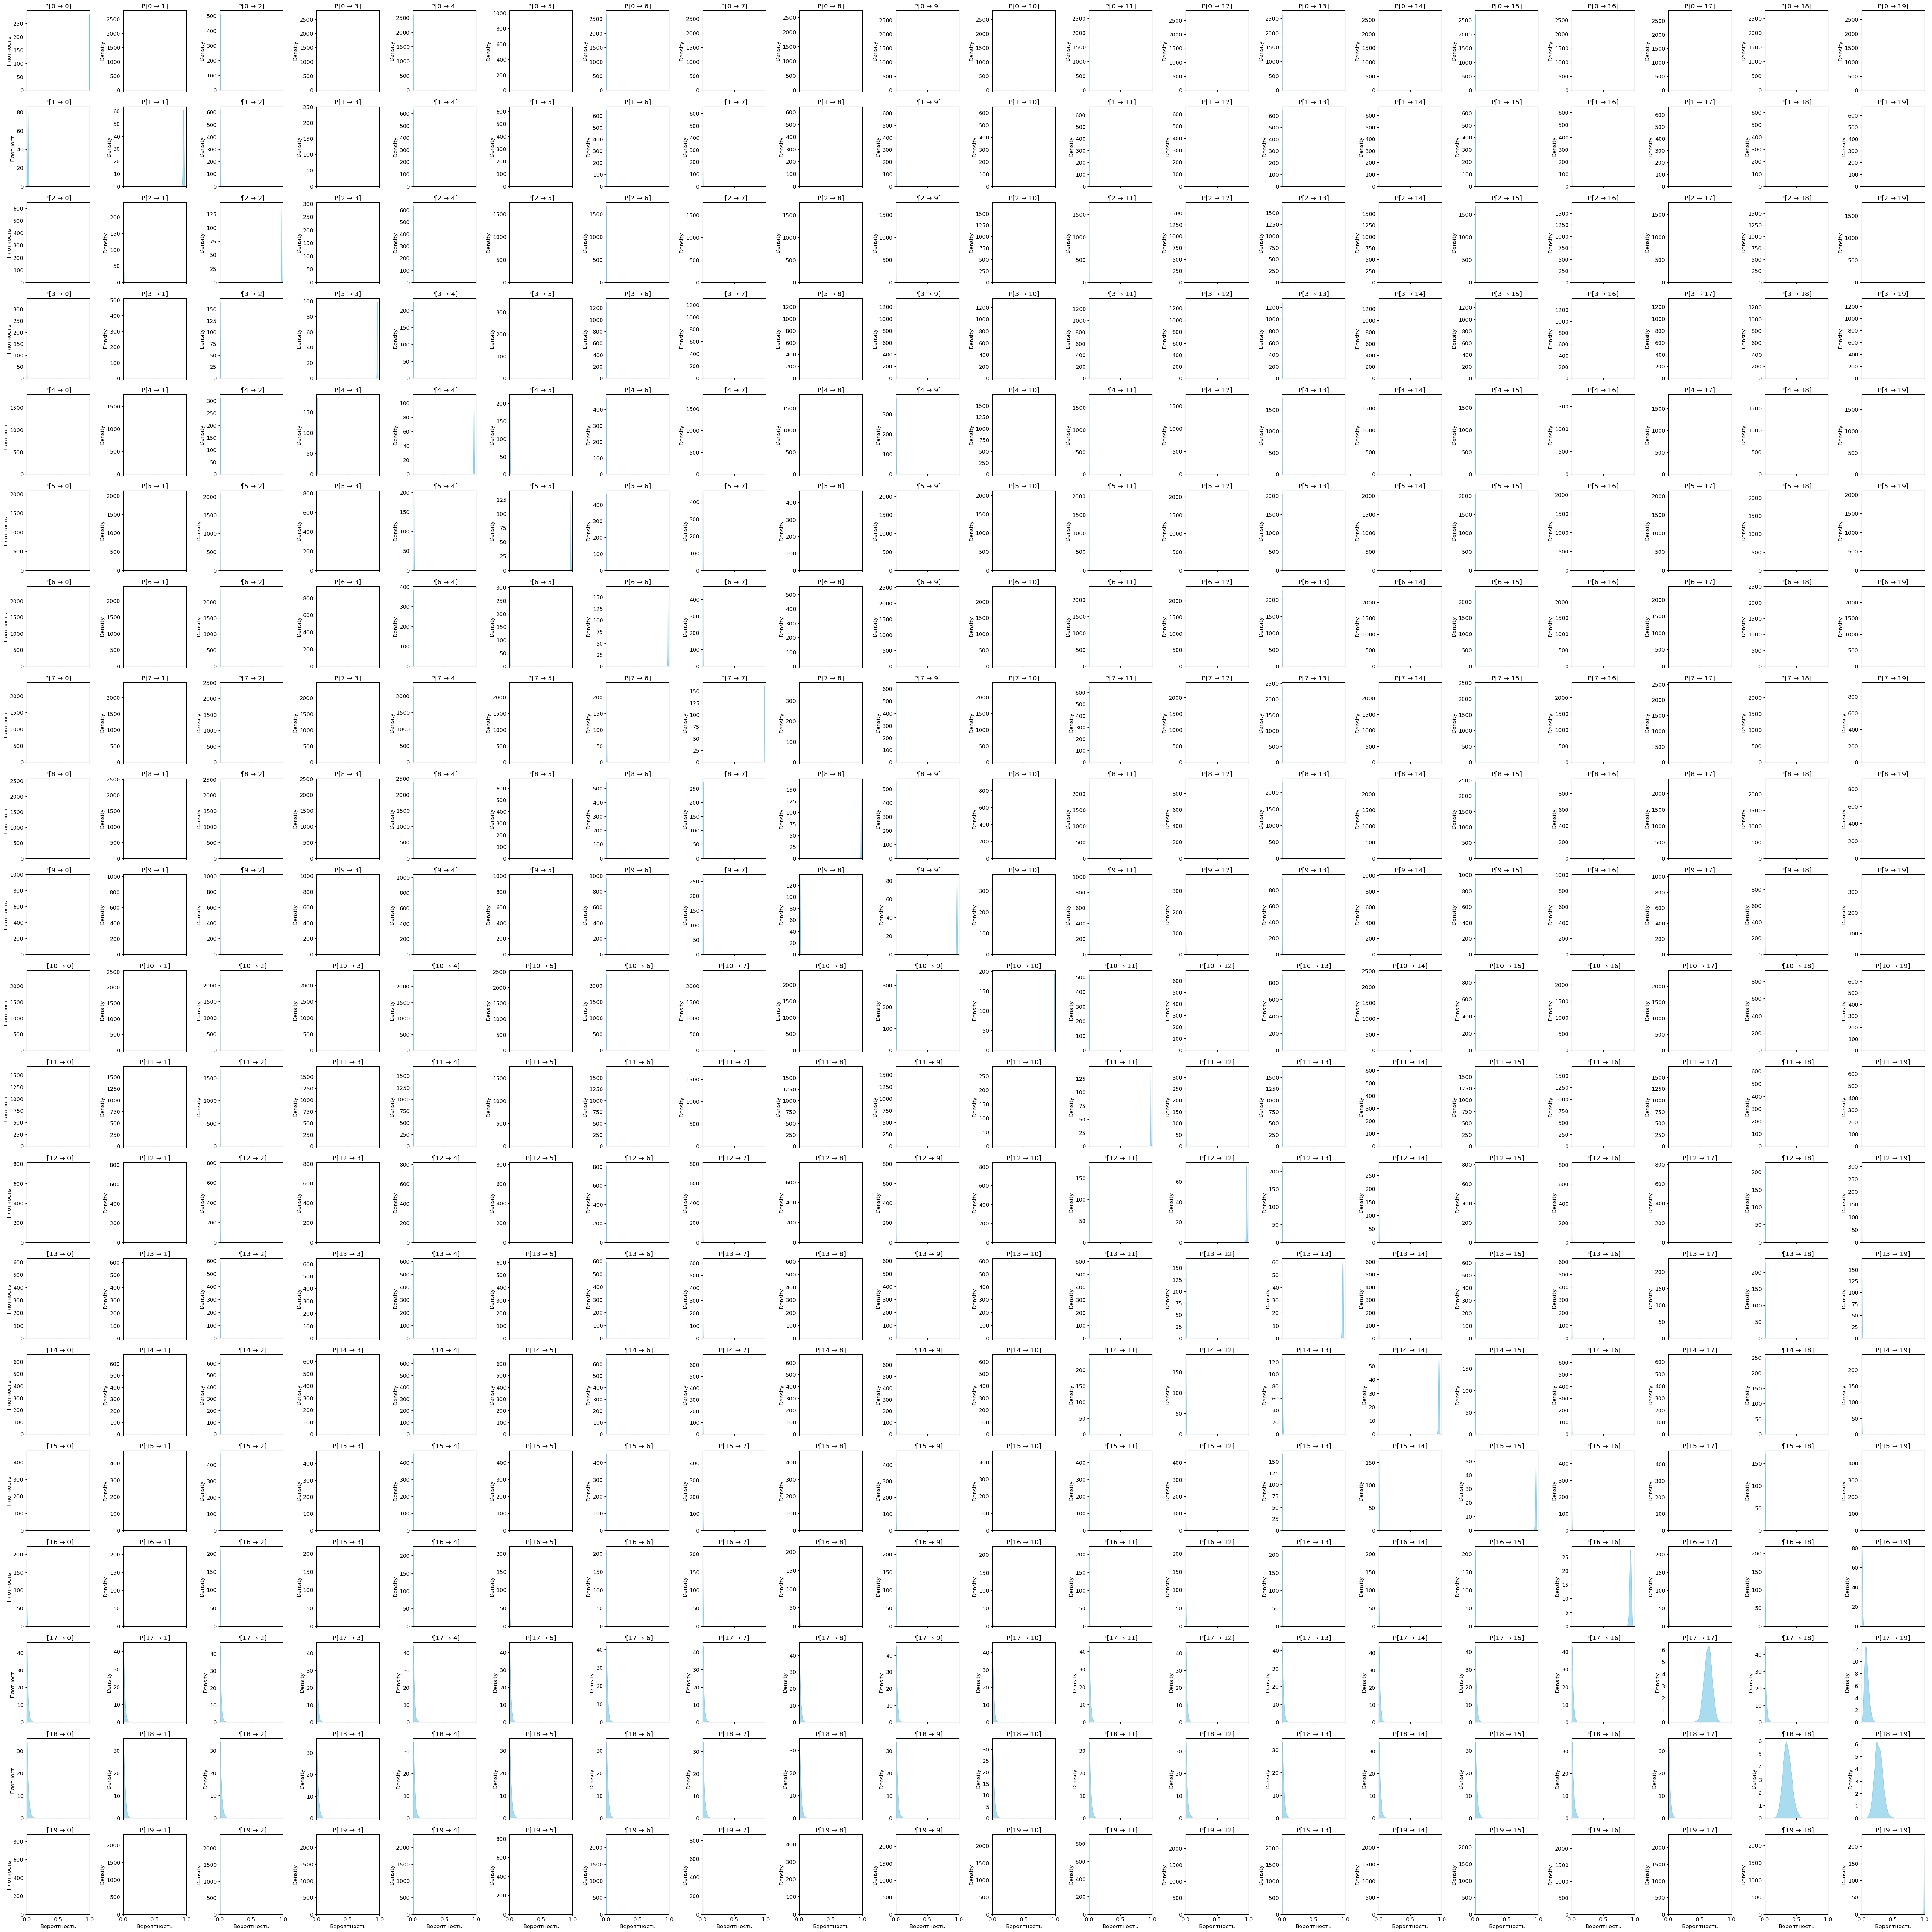

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

def extract_samples_from_trace(trace, var_name="P"):
    """
    Извлекает выборки из pymc.trace.posterior[var_name]
    и преобразует в словарь вида {"P[i,j]": выборки}
    """
    samples_raw = trace.posterior[var_name].values  # shape = (chains, draws, i, j)
    n_states = samples_raw.shape[2]

    samples = {
        f"P[{i},{j}]": samples_raw[:, :, i, j].flatten()
        for i in range(n_states)
        for j in range(n_states)
    }

    return samples, n_states

def plot_transition_distributions(samples, n_states):
    """
    Строит графики плотности распределений для каждой вероятности P[i,j]
    """
    if not isinstance(samples, dict):
        raise TypeError("Ожидался словарь samples, но получен: " + str(type(samples)))

    fig, axes = plt.subplots(n_states, n_states, figsize=(3 * n_states, 3 * n_states), sharex=True)

    if n_states == 1:
        axes = np.array([[axes]])
    elif axes.ndim == 1:
        axes = axes.reshape((n_states, n_states))

    for i in range(n_states):
        for j in range(n_states):
            key = f"P[{i},{j}]"
            data = samples[key]

            ax = axes[i, j]
            sns.kdeplot(data, ax=ax, fill=True, color="skyblue", alpha=0.7)
            ax.set_title(f"P[{i} → {j}]")
            ax.set_xlim(0, 1)

            if i == n_states - 1:
                ax.set_xlabel("Вероятность")
            if j == 0:
                ax.set_ylabel("Плотность")

    plt.tight_layout()
    plt.show()

# --- Пример использования (предположим, у вас уже есть `trace`) ---

# Замените на ваш объект InferenceData, например:
# import pymc as pm
# trace = pm.sample(...)
# Или загрузите:
# trace = az.from_netcdf("path_to_trace.nc")

samples, n_states = extract_samples_from_trace(trace, var_name="P")
plot_transition_distributions(samples, n_states)
